In [1]:
import warnings
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from prophet.plot import plot_components

In [2]:
# Load the CSV as strings
df = pd.read_csv('mixed_dataset.csv', dtype=str)

#  Rename columns
df.rename(columns={
    'dt': 'Date',
    'LandAverageTemperature': 'LandAvgTemp'
}, inplace=True)

#  Split based on known format
# Format A: YYYY-MM-DD (before 1900)
df_iso = df[df['Date'].str.contains(r'\d{4}-\d{2}-\d{2}', na=False)].copy()
df_iso['Date'] = pd.to_datetime(df_iso['Date'], format='%Y-%m-%d', errors='coerce')

# Format B: DD/MM/YYYY (after 1900)
df_dmy = df[~df.index.isin(df_iso.index)].copy()
df_dmy['Date'] = pd.to_datetime(df_dmy['Date'], format='%d/%m/%Y', errors='coerce')

#  Combine both parsed subsets
df = pd.concat([df_iso, df_dmy])

#  Drop NaTs, filter, and clean
df.dropna(subset=['Date'], inplace=True)
df = df[df['Date'] >= '1900-01-01']
df['LandAvgTemp'] = pd.to_numeric(df['LandAvgTemp'], errors='coerce')
df.dropna(subset=['LandAvgTemp'], inplace=True)
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

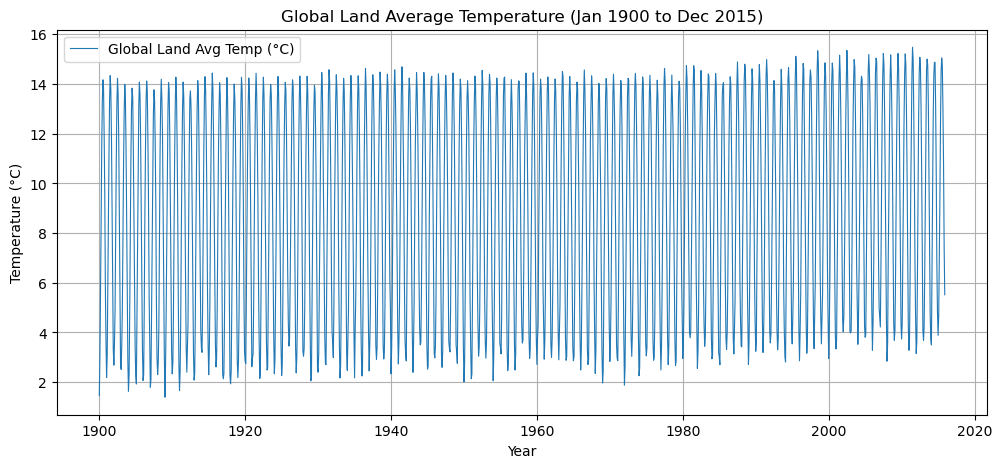

In [3]:
#  Plot the Entire Time Series
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['LandAvgTemp'], label='Global Land Avg Temp (°C)', alpha=0.99, linewidth=0.8)
plt.title('Global Land Average Temperature (Jan 1900 to Dec 2015)')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)

plt.show()

In [4]:
data = df['LandAvgTemp'].copy()

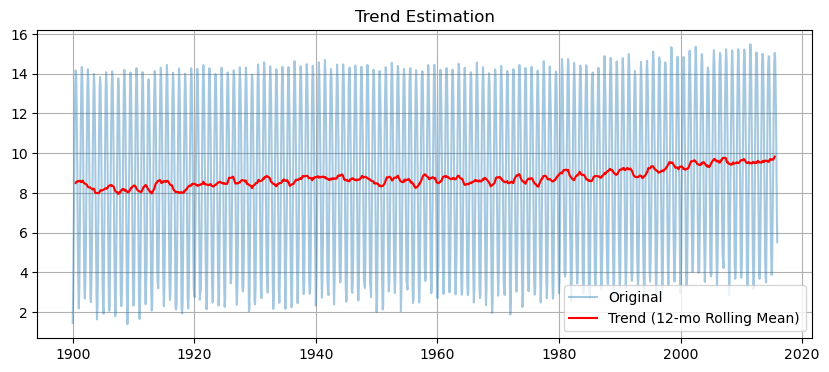

In [5]:
# Calculate the rolling average to estimate the trend (12 months = 1 year)
trend = data.rolling(window=12, center=True).mean()

# Plot the trend
plt.figure(figsize=(10, 4))
plt.plot(data, label='Original', alpha = 0.4, )
plt.plot(trend, label='Trend (12-mo Rolling Mean)', color='red')
plt.title('Trend Estimation')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/70/j3k4b6rs2td_qct103mycf2c0000gn/T/ipykernel_68350/1525512692.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_data = data.resample('Y').mean()


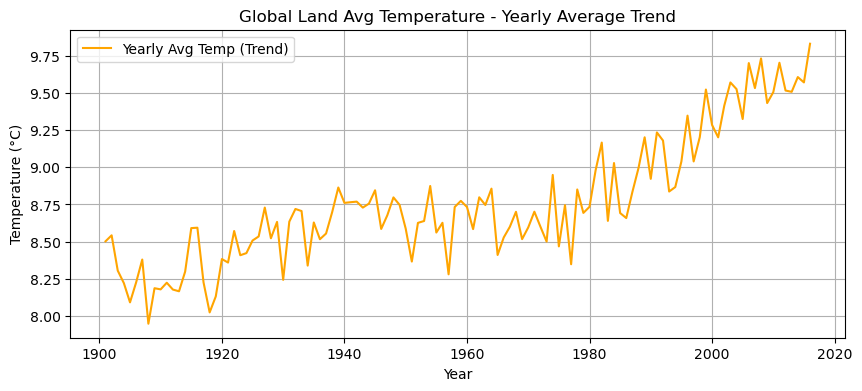

In [6]:
# Resample the temperature data to yearly frequency and compute the mean
yearly_data = data.resample('Y').mean()

# Plot the yearly average trend
plt.figure(figsize=(10, 4))
plt.plot(yearly_data, label='Yearly Avg Temp (Trend)', color='orange')
plt.title('Global Land Avg Temperature - Yearly Average Trend')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

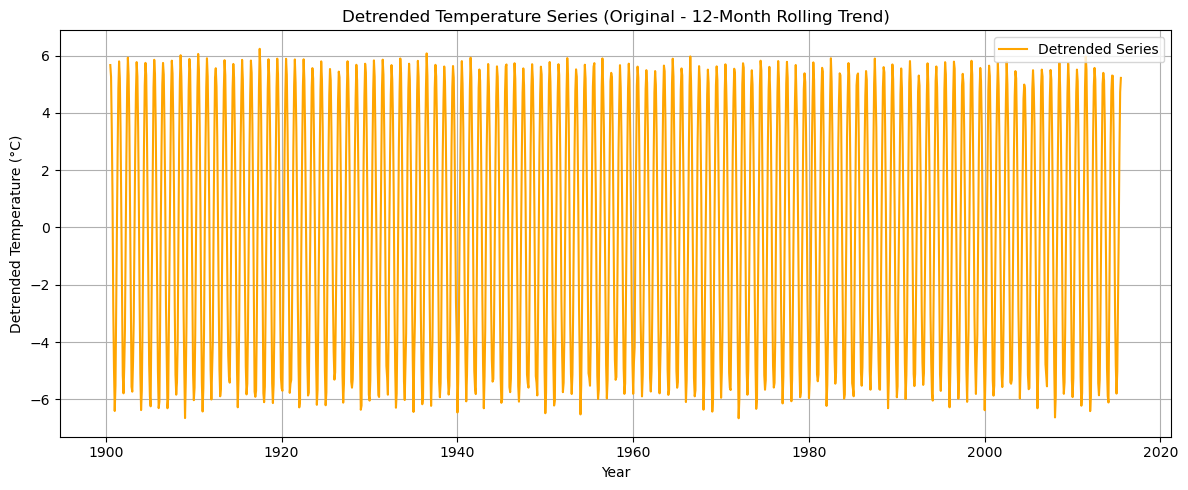

In [7]:
# Compute 12-month rolling average (the trend)
rolling_trend = df['LandAvgTemp'].rolling(window=12, center=True).mean()

# Align data by dropping NaNs introduced by rolling
valid_index = rolling_trend.dropna().index
aligned_data = df['LandAvgTemp'].loc[valid_index]
aligned_trend = rolling_trend.loc[valid_index]

#  Subtract trend from data
detrended = aligned_data - aligned_trend

#  Plot detrended series
plt.figure(figsize=(12, 5))
plt.plot(detrended.index, detrended, label='Detrended Series', color='orange')
plt.title('Detrended Temperature Series (Original - 12-Month Rolling Trend)')
plt.xlabel('Year')
plt.ylabel('Detrended Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

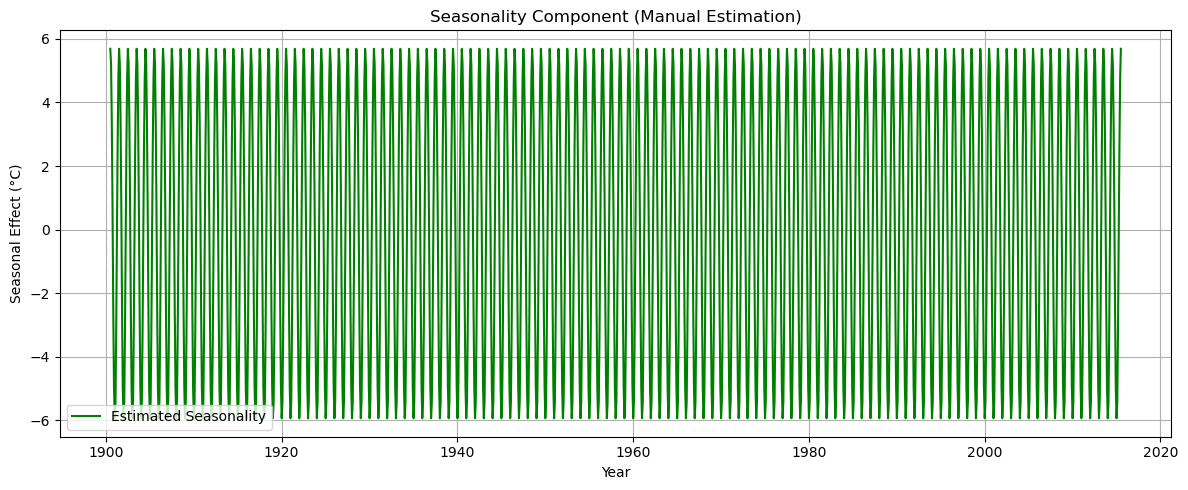


Monthly Seasonal Averages:
Date
1    -5.932
2    -5.427
3    -3.366
4    -0.222
5     2.633
6     4.779
7     5.687
8     5.197
9     3.403
10    0.759
11   -2.545
12   -4.961
Name: LandAvgTemp, dtype: float64


In [8]:
#  Extract the month (1–12) for each detrended value
months = pd.Series(detrended.index.month, index=detrended.index)

#  Group detrended values by month and compute the mean for each month
monthly_seasonal_values = detrended.groupby(months).mean()

# Map the monthly seasonality values back to each data point
seasonality = months.map(monthly_seasonal_values)

#  Plot the seasonality
plt.figure(figsize=(12, 5))
plt.plot(detrended.index, seasonality, label='Estimated Seasonality', color='green')
plt.title('Seasonality Component (Manual Estimation)')
plt.xlabel('Year')
plt.ylabel('Seasonal Effect (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nMonthly Seasonal Averages:")
print(monthly_seasonal_values.round(3))


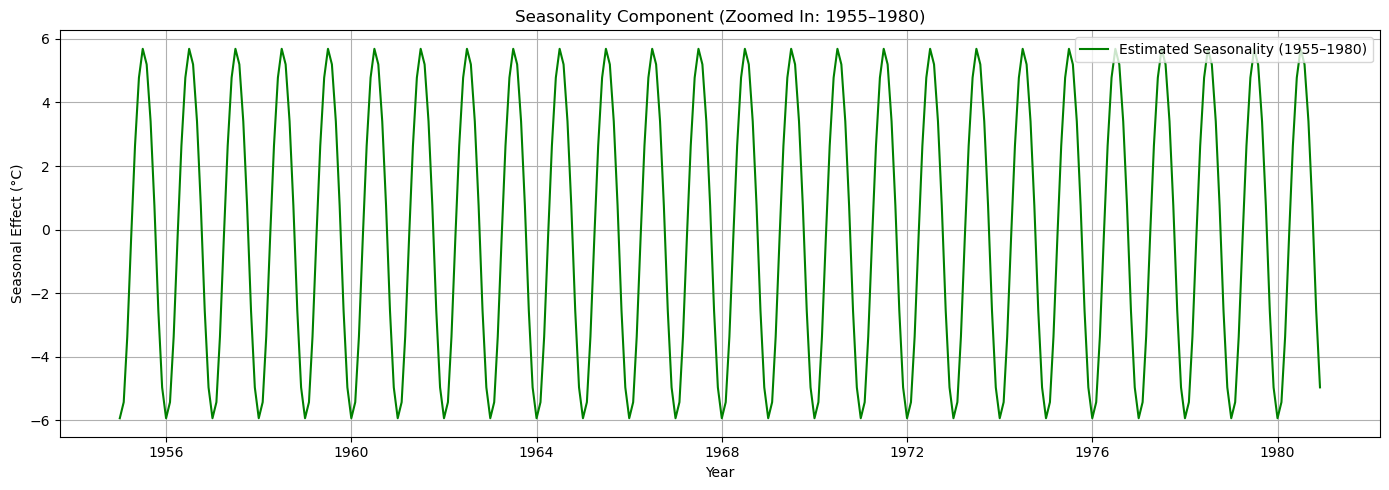

In [9]:
# Filter the period 1950–2000 for better visualization
zoom_range = seasonality[(seasonality.index.year >= 1955) & (seasonality.index.year <= 1980)]

plt.figure(figsize=(14, 5))
plt.plot(zoom_range.index, zoom_range.values, label='Estimated Seasonality (1955–1980)', color='green')
plt.title('Seasonality Component (Zoomed In: 1955–1980)')
plt.xlabel('Year')
plt.ylabel('Seasonal Effect (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


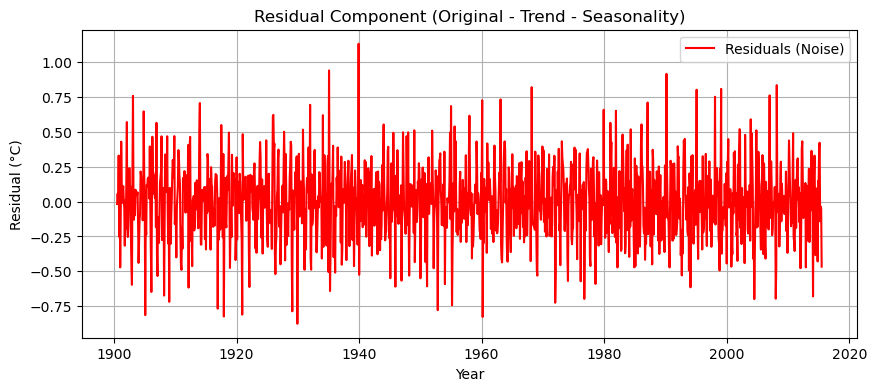

In [10]:
# Residual = Original - Trend - Seasonality
residual = aligned_data - aligned_trend - seasonality

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residual, label='Residuals (Noise)', color='red')
plt.title('Residual Component (Original - Trend - Seasonality)')
plt.xlabel('Year')
plt.ylabel('Residual (°C)')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller

# Run the ADF test
adf_result = adfuller(residual.dropna())

# Print results
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")


ADF Statistic: -15.658691940308145
p-value: 1.5637460312378053e-28
Critical Values:
   1%: -3.4351745242248715
   5%: -2.8636706623947417
   10%: -2.567904365598721


### **part 2:**

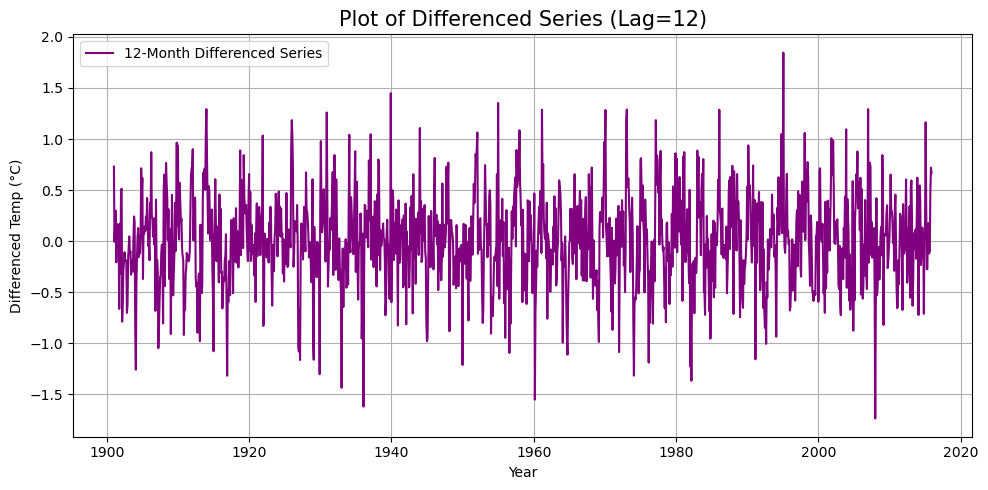

In [12]:
# 12-month seasonal differencing to remove yearly seasonality
data_diff = df['LandAvgTemp'].diff(periods=12)
data_diff = data_diff.dropna()

# Plot the differenced series
plt.figure(figsize=(10, 5))
plt.plot(data_diff, label='12-Month Differenced Series', color='purple')
plt.title("Plot of Differenced Series (Lag=12)", fontsize=15)
plt.xlabel('Year')
plt.ylabel('Differenced Temp (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 200x200 with 0 Axes>

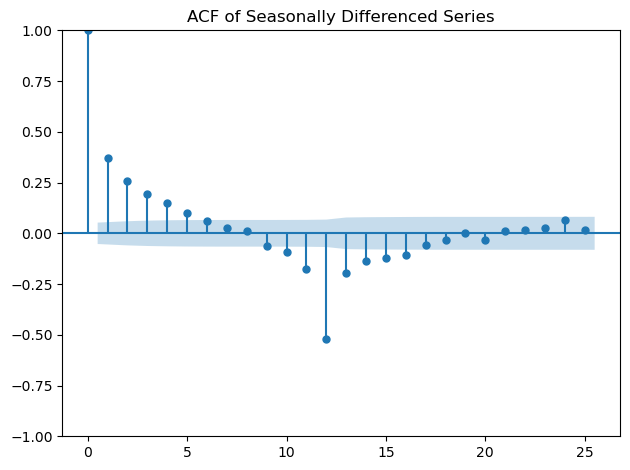

In [13]:
# ACF plot (lags=25)
plt.figure(figsize=(2, 2))
sm.graphics.tsa.plot_acf(data_diff, lags=25)
plt.title('ACF of Seasonally Differenced Series')
plt.tight_layout()
plt.show()

<Figure size 200x200 with 0 Axes>

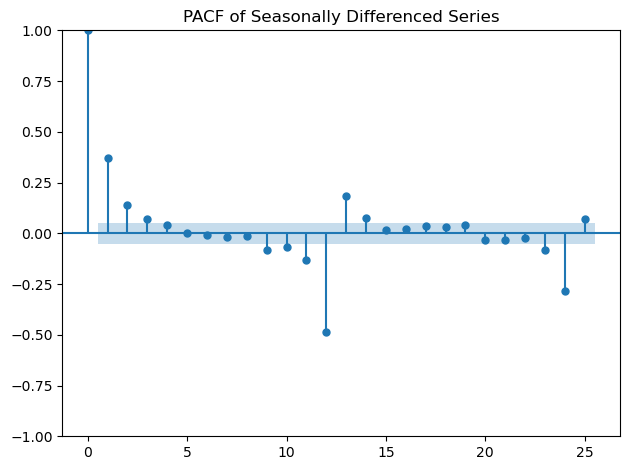

In [14]:
# PACF plot (lags=25)
plt.figure(figsize=(2, 2))
sm.graphics.tsa.plot_pacf(data_diff, lags=25, method='ywm')
plt.title('PACF of Seasonally Differenced Series')
plt.tight_layout()
plt.show()
plt.show()

BIC for each SARIMA candidate:



/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(1,1,1)(1,1,1)[12] --> BIC: 611.79


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,1,2)(1,1,1)[12] --> BIC: 590.30


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(2,1,1)(2,1,1)[12] --> BIC: 602.36


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(1,1,2)(1,1,2)[12] --> BIC: 580.44


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(2,1,0)(2,1,1)[12] --> BIC: 776.36

 Best model based on BIC:
Best SARIMA(1,1,2)(1,1,2)[12] with BIC: 580.44


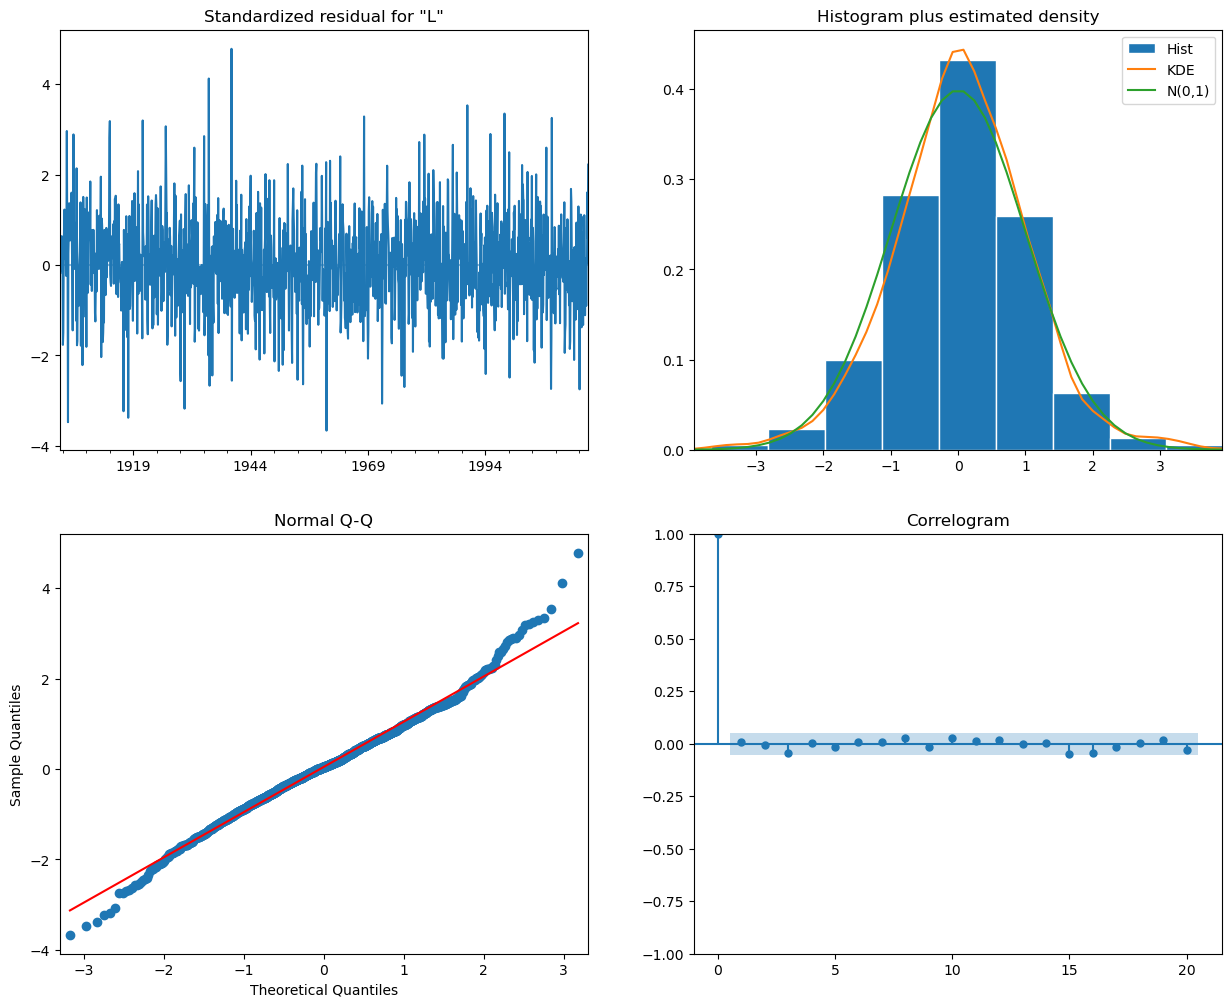

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Define the list of candidate models: (p, d, q, P, D, Q, s)
candidates = [
    (1, 1, 1, 1, 1, 1, 12),
    (2, 1, 2, 1, 1, 1, 12),
    (2, 1, 1, 2, 1, 1, 12),
    (1, 1, 2, 1, 1, 2, 12),
    (2, 1, 0, 2, 1, 1, 12)
]

best_bic = np.inf
best_model = None
best_order = None

print("BIC for each SARIMA candidate:\n")

for order in candidates:
    p, d, q, P, D, Q, s = order
    try:
        model = SARIMAX(df['LandAvgTemp'],
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, s),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        result = model.fit(disp=False)
        bic = result.bic
        print(f"SARIMA({p},{d},{q})({P},{D},{Q})[{s}] --> BIC: {bic:.2f}")

        if bic < best_bic:
            best_bic = bic
            best_model = result
            best_order = order

    except Exception as e:
        print(f"Model SARIMA({p},{d},{q})({P},{D},{Q})[{s}] failed: {e}")

# Final chosen model
if best_model:
    print("\n Best model based on BIC:")
    p, d, q, P, D, Q, s = best_order
    print(f"Best SARIMA({p},{d},{q})({P},{D},{Q})[{s}] with BIC: {best_bic:.2f}")

# Optional: Plot diagnostics for the best model
best_model.plot_diagnostics(lags=20, figsize=(15, 12))
plt.show()

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the model
model = SARIMAX(df['LandAvgTemp'],
                order=(0, 1, 2),
                seasonal_order=(0, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
result = model.fit(disp=False)

# Print BIC
print(f"BIC for SARIMA(0,1,2)(0,1,1)[12]: {result.bic:.2f}")


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


BIC for SARIMA(0,1,2)(0,1,1)[12]: 620.40


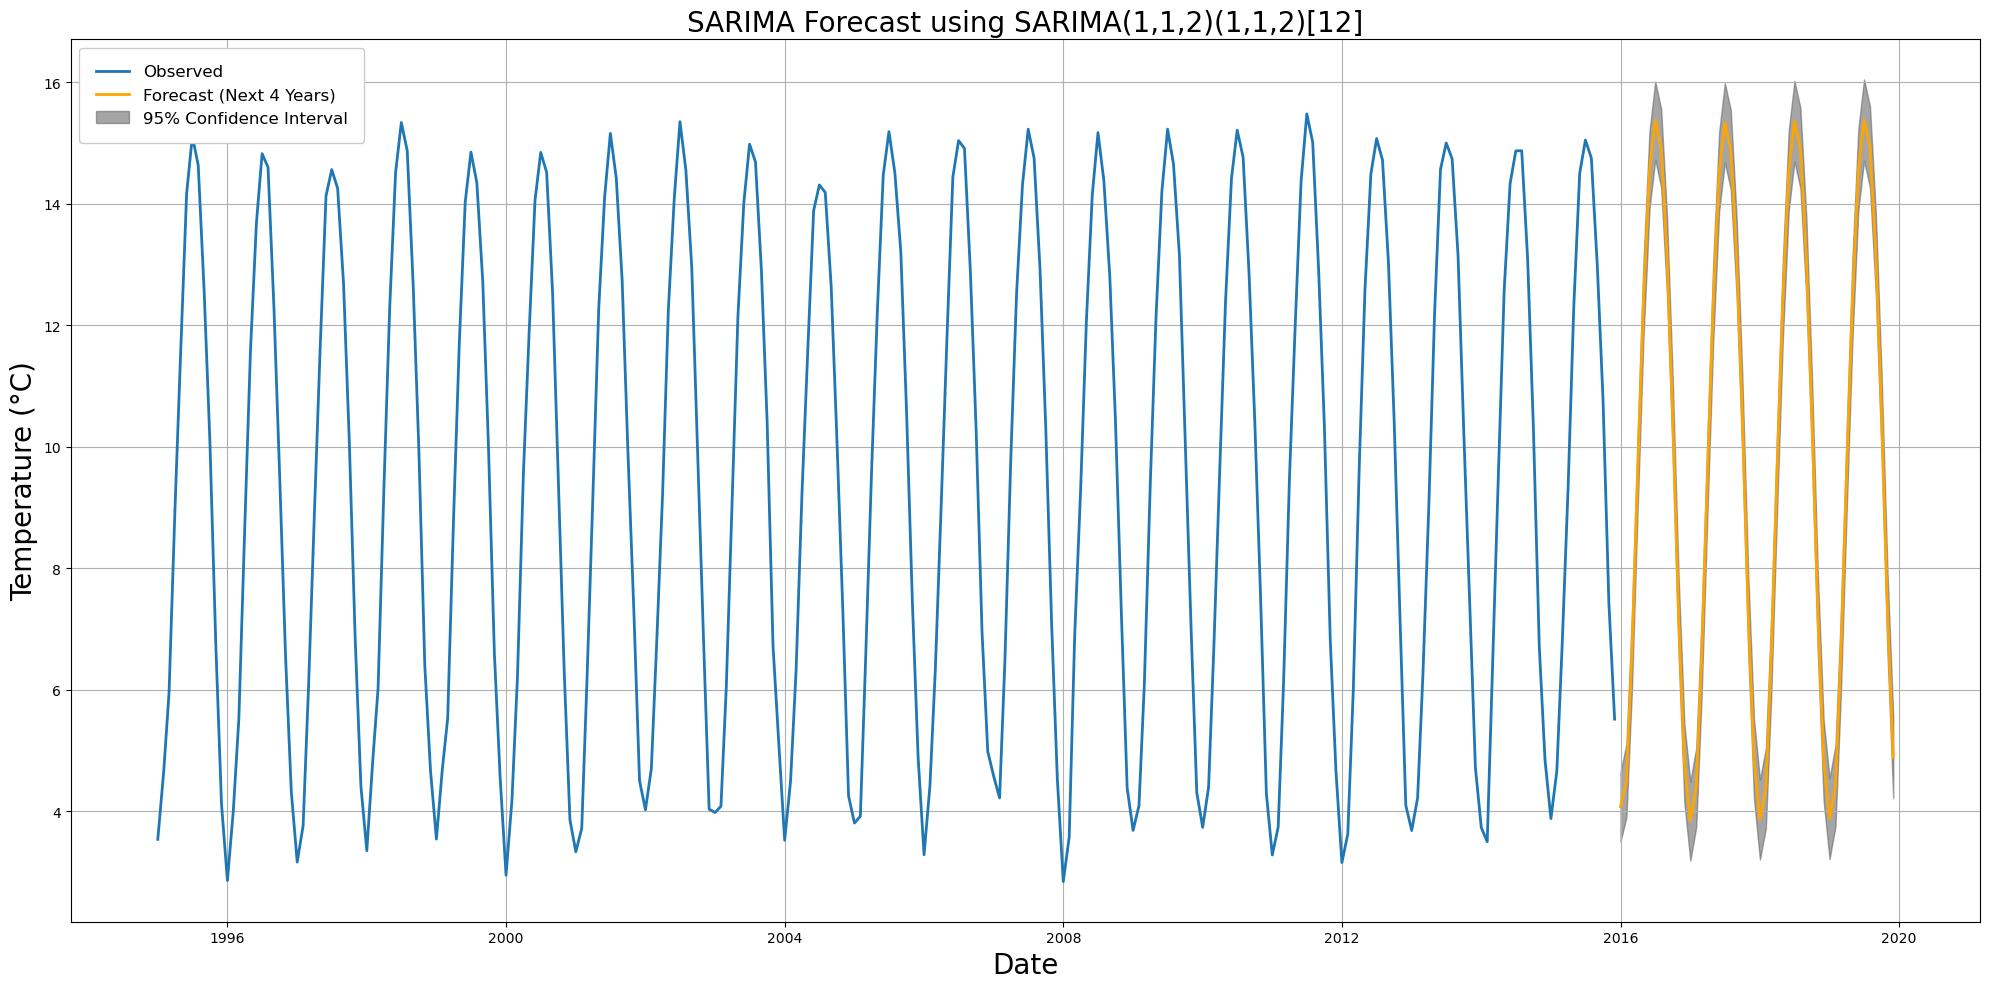

In [17]:
# Make sure best_model_name is defined (if not carried over from earlier cell)
best_model_name = "SARIMA(1,1,2)(1,1,2)[12]"  # or whatever string you want for display

# Define forecast horizon
FORECAST_STEPS = 48  # Forecast 4 years

#  Generate forecast from the best model
forecast_result = best_model.get_forecast(steps=FORECAST_STEPS)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

#  Create future datetime index
last_date = df.index[-1]
future_index = pd.date_range(start=last_date + pd.DateOffset(months=1),
                             periods=FORECAST_STEPS, freq='MS')

#  Create forecast DataFrame
forecast_df = pd.DataFrame(forecast_mean.values, index=future_index, columns=['Forecast'])

#  Plot the observed series with forecast
plt.figure(figsize=(20, 10))
start_zoom = '1995-01-01'
plt.plot(df['LandAvgTemp'].loc[start_zoom:], label='Observed', linewidth=2)
plt.plot(forecast_df, label='Forecast (Next 4 Years)', color='orange', linewidth=2)

# Improved confidence interval shading
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='dimgray', alpha=0.6, label='95% Confidence Interval')

# Labels and title
plt.xlabel('Date', fontsize=20)
plt.ylabel('Temperature (°C)', fontsize=20)
plt.title(f"SARIMA Forecast using {best_model_name}", fontsize=20)

# Improved legend styling
plt.legend(loc='upper left', fontsize=12, frameon=True, fancybox=True, framealpha=1, borderpad=1)

plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use the cleaned monthly data (with equal spacing)
y = df['LandAvgTemp'].copy()
y = y.dropna()
y = y.values
n = len(y)
T = 12  # Monthly seasonality
K = T // 2  # Number of harmonics = 6

# Time index
t = np.arange(1, n + 1)

# Estimate alpha_0
alpha_0 = np.mean(y)

# Initialize arrays
alpha_hat = []
beta_hat = []

for k in range(1, K + 1):
    lam_k = 2 * np.pi * k / T
    alpha_k = (2 / n) * np.sum(y * np.cos(lam_k * t))
    beta_k = (2 / n) * np.sum(y * np.sin(lam_k * t))
    alpha_hat.append(alpha_k)
    beta_hat.append(beta_k)

# Show estimated coefficients
print(f"α₀ = {alpha_0:.4f}")
for k in range(1, K + 1):
    print(f"α̂_{k} = {alpha_hat[k-1]:.4f}, β̂_{k} = {beta_hat[k-1]:.4f}")


α₀ = 8.7625
α̂_1 = -4.8502, β̂_1 = -3.3440
α̂_2 = -0.0743, β̂_2 = -0.1629
α̂_3 = -0.0151, β̂_3 = 0.0514
α̂_4 = -0.0339, β̂_4 = 0.0607
α̂_5 = 0.0012, β̂_5 = 0.0099
α̂_6 = 0.0434, β̂_6 = -0.0000


In [19]:
print("alpha_hat:", alpha_hat)
print("beta_hat:", beta_hat)
print("K =", len(alpha_hat))

alpha_hat: [-4.850170476452435, -0.07431824712645876, -0.015107758620683366, -0.03386135057469763, 0.0012092695557568958, 0.04341666666666681]
beta_hat: [-3.343972751086735, -0.1628936547207361, 0.051449712643674254, 0.06073252001914628, 0.009892291316795207, -2.0070870531230263e-14]
K = 6


I_k values (Fourier Periodogram):
Harmonic k=1 (Period = 12): I_k = 24155.59
Harmonic k=2 (Period = 6): I_k = 22.31
Harmonic k=3 (Period = 4): I_k = 2.00
Harmonic k=4 (Period = 3): I_k = 3.37
Harmonic k=5 (Period = 2): I_k = 0.07
Harmonic k=6 (Period = 2): I_k = 1.31


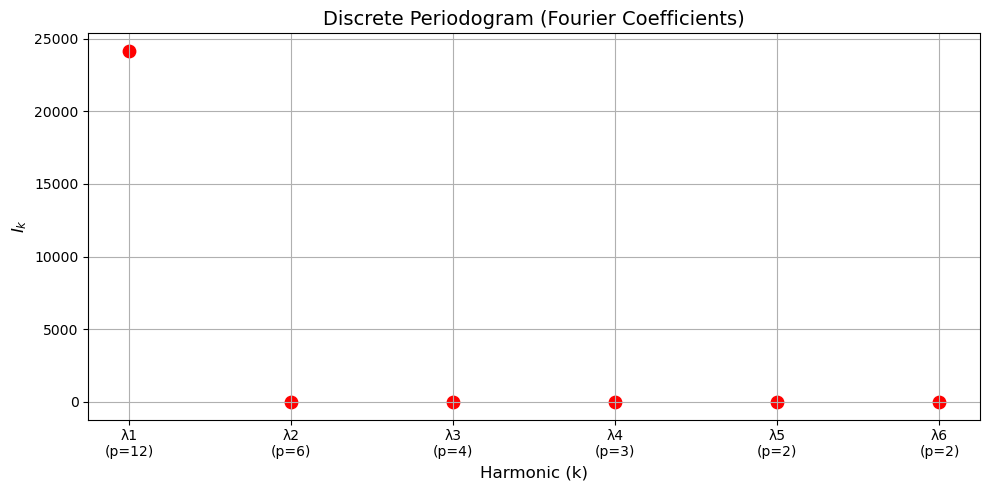

In [20]:
# Compute and print I_k values
I_k = [(n / 2) * (a**2 + b**2) for a, b in zip(alpha_hat, beta_hat)]

print("I_k values (Fourier Periodogram):")
for k, ik in enumerate(I_k, 1):
    period = int(T / k)
    print(f"Harmonic k={k} (Period = {period}): I_k = {ik:.2f}")

# Dot-style scatter plot (like the slide)
plt.figure(figsize=(10, 5))
plt.scatter(range(1, K+1), I_k, color='red', s=80)
plt.xticks(range(1, K+1), [f'λ{k}\n(p={int(T/k)})' for k in range(1, K+1)])
plt.ylabel('$I_k$', fontsize=12)
plt.xlabel('Harmonic (k)', fontsize=12)
plt.title('Discrete Periodogram (Fourier Coefficients)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
from scipy.stats import f

#  Reconstruct fitted values using the Fourier series
lam = [2 * np.pi * k / T for k in range(1, K+1)]
y_hat = np.full(n, alpha_0)

for k in range(K):
    y_hat += alpha_hat[k] * np.cos(lam[k] * t) + beta_hat[k] * np.sin(lam[k] * t)

#  Residual sum of squares
residuals = y - y_hat
SSRes = np.sum(residuals**2)

#  Explained sum of squares (from I_k)
SSReg = np.sum(I_k)

#  Global F-test (Test 1: Are there any cycles?)
F_global = (SSReg / (T - 1)) / (SSRes / (n - T))
F_crit_global = f.ppf(0.95, T - 1, n - T)

print(f"Global F-statistic: {F_global:.2f}")
print(f"Critical value (95%): {F_crit_global:.2f}")
print("Reject H0 (no cycles)?", F_global > F_crit_global)

#  Individual tests (Test 2: Is cycle k significant?)
F_k = [(ik / 2) / (SSRes / (n - T)) for ik in I_k]
F_crit_individual = f.ppf(0.95, 2, n - T)

print("\nIndividual F-tests for each harmonic:")
for k in range(1, K+1):
    reject = F_k[k-1] > F_crit_individual
    print(f"Cycle k={k} (period {int(T/k)}): F={F_k[k-1]:.2f} → Reject H0? {reject}")


Global F-statistic: 8585.02
Critical value (95%): 1.80
Reject H0 (no cycles)? True

Individual F-tests for each harmonic:
Cycle k=1 (period 12): F=47160.88 → Reject H0? True
Cycle k=2 (period 6): F=43.56 → Reject H0? True
Cycle k=3 (period 4): F=3.91 → Reject H0? True
Cycle k=4 (period 3): F=6.57 → Reject H0? True
Cycle k=5 (period 2): F=0.13 → Reject H0? False
Cycle k=6 (period 2): F=2.56 → Reject H0? False


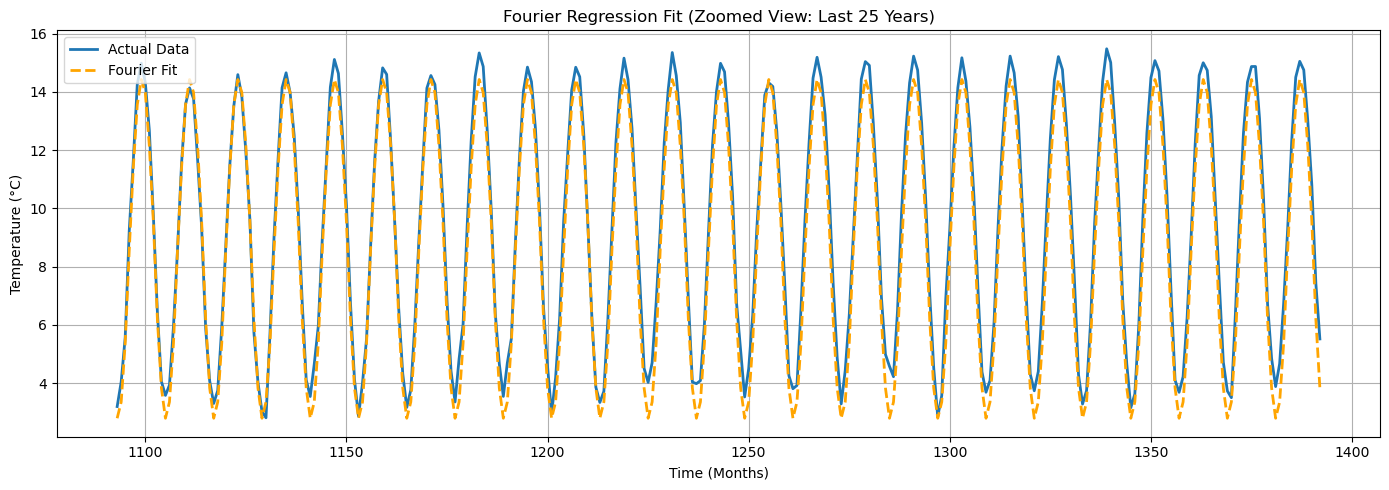

In [22]:
# Zoom into the last 300 months (25 years)
plt.figure(figsize=(14, 5))
plt.plot(t[-300:], y[-300:], label='Actual Data', linewidth=2)
plt.plot(t[-300:], y_hat[-300:], label='Fourier Fit', linestyle='--', linewidth=2, color='orange')
plt.title('Fourier Regression Fit (Zoomed View: Last 25 Years)')
plt.xlabel('Time (Months)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


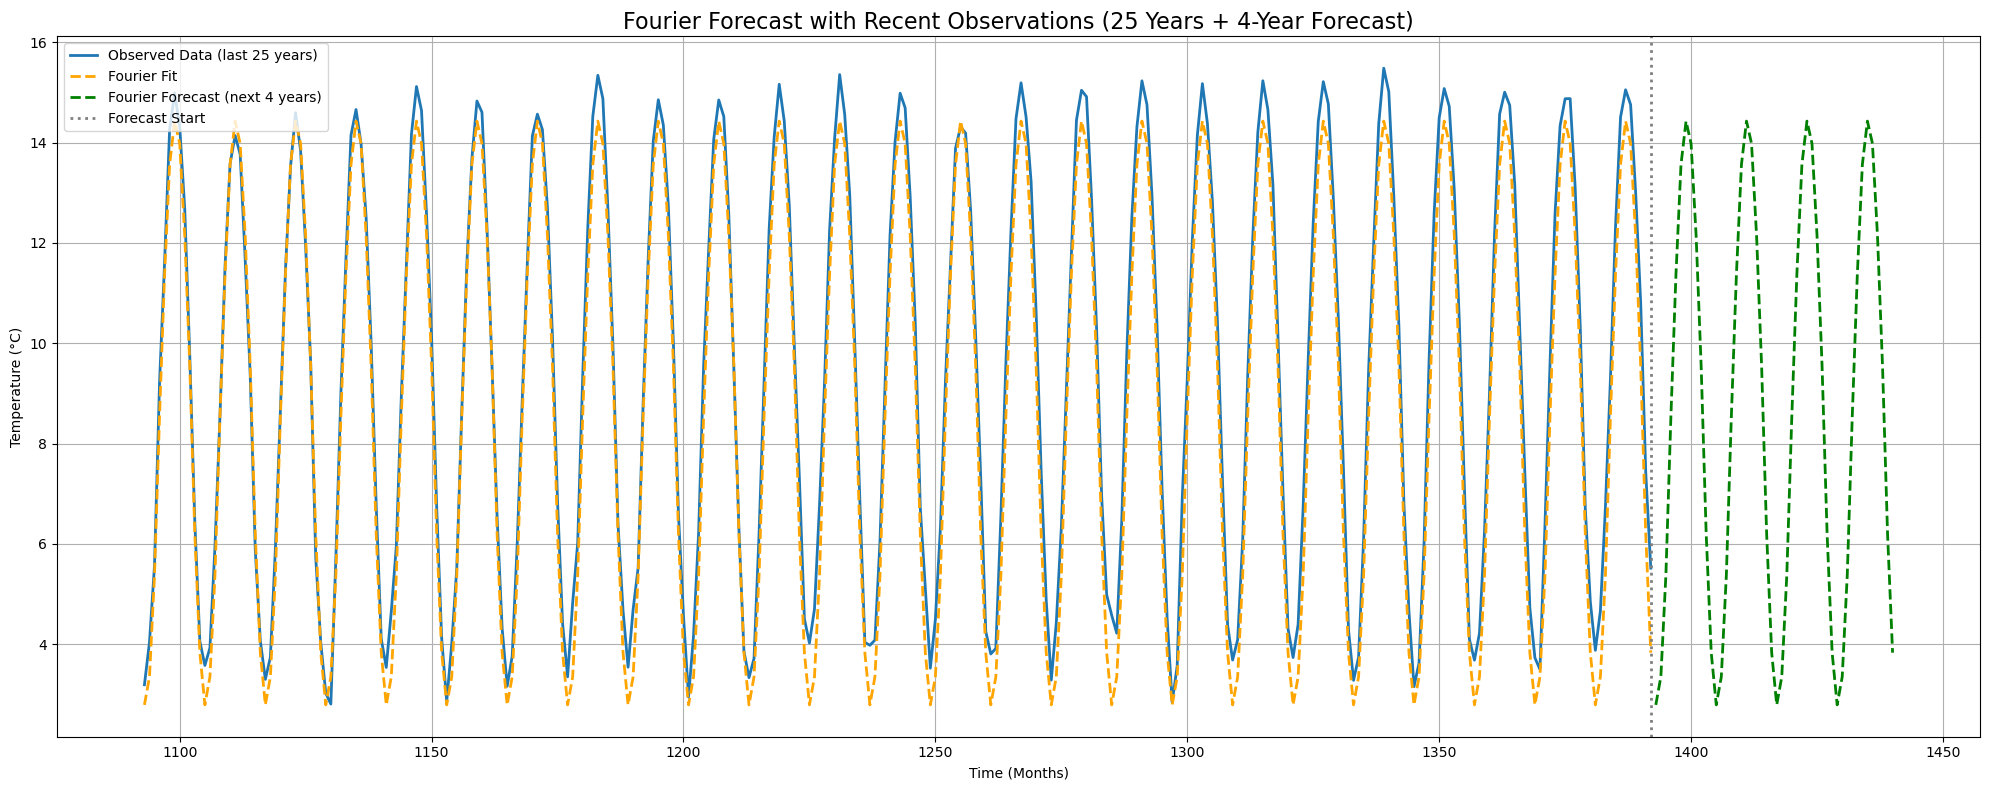

In [23]:
#  Recompute lambda_k
lambda_k = [2 * np.pi * k / T for k in range(1, K + 1)]

#  Forecasting horizon
forecast_horizon = 48  # Next 4 years
t_future = np.arange(n + 1, n + forecast_horizon + 1)

#  Forecast using Fourier model
y_forecast = np.full(forecast_horizon, alpha_0)
for k in range(K):
    y_forecast += alpha_hat[k] * np.cos(lambda_k[k] * t_future) + beta_hat[k] * np.sin(lambda_k[k] * t_future)

#  Combine for plotting
t_combined = np.concatenate([t[-300:], t_future])
y_combined = np.concatenate([y[-300:], y_forecast])
y_fit_combined = np.concatenate([y_hat[-300:], [np.nan]*forecast_horizon])  # fit only for real data

#  Plot zoomed view
plt.figure(figsize=(20, 8))
plt.plot(t[-300:], y[-300:], label='Observed Data (last 25 years)', linewidth=2)
plt.plot(t[-300:], y_hat[-300:], label='Fourier Fit', linestyle='--', color='orange', linewidth=2)
plt.plot(t_future, y_forecast, label='Fourier Forecast (next 4 years)', linestyle='--', color='green', linewidth=2)

plt.axvline(x=n, color='gray', linestyle=':', linewidth=2, label='Forecast Start')
plt.title('Fourier Forecast with Recent Observations (25 Years + 4-Year Forecast)', fontsize=16)
plt.xlabel('Time (Months)')
plt.ylabel('Temperature (°C)')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


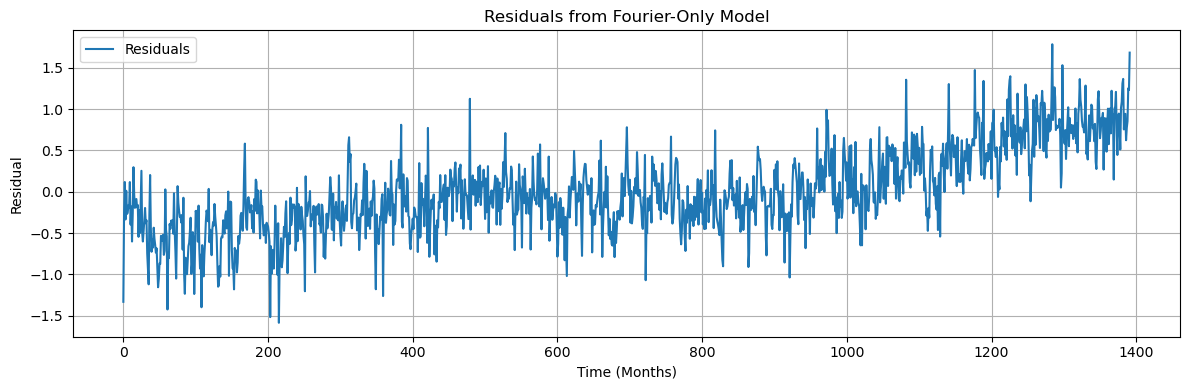

In [24]:
residuals = y - y_hat
plt.figure(figsize=(12, 4))
plt.plot(residuals, label='Residuals')
plt.title('Residuals from Fourier-Only Model')
plt.xlabel('Time (Months)')
plt.ylabel('Residual')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

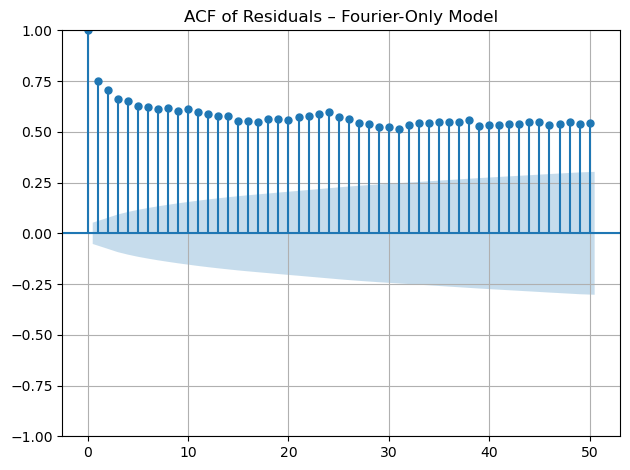

In [25]:
plt.figure(figsize=(10, 5))
plot_acf(residuals, lags=50, title='ACF of Residuals – Fourier-Only Model')
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
#  Prepare time variable (t already defined from 1 to n)

#  Create Fourier basis matrix
X_fourier = []
for i in range(n):
    row = [1, t[i]]  # Intercept and time (trend)
    for k in range(1, K + 1):
        lam = 2 * np.pi * k / T
        row.append(np.cos(lam * t[i]))
        row.append(np.sin(lam * t[i]))
    X_fourier.append(row)

# Convert to numpy matrix
X = np.array(X_fourier)  # Shape: (n, 2 + 2*K)

#  Solve for regression coefficients using normal equation
# theta_hat = (X^T X)^(-1) X^T y
XtX = X.T @ X
Xty = X.T @ y
theta_hat = np.linalg.inv(XtX) @ Xty

# Display theta_hat
print("Estimated regression coefficients:")
for i, coeff in enumerate(theta_hat):
    print(f"θ[{i}] = {coeff:.4f}")


Estimated regression coefficients:
θ[0] = 8.1417
θ[1] = 0.0009
θ[2] = -4.8511
θ[3] = -3.3407
θ[4] = -0.0752
θ[5] = -0.1613
θ[6] = -0.0160
θ[7] = 0.0524
θ[8] = -0.0348
θ[9] = 0.0613
θ[10] = 0.0003
θ[11] = 0.0101
θ[12] = 0.0206
θ[13] = -7178562806.5528


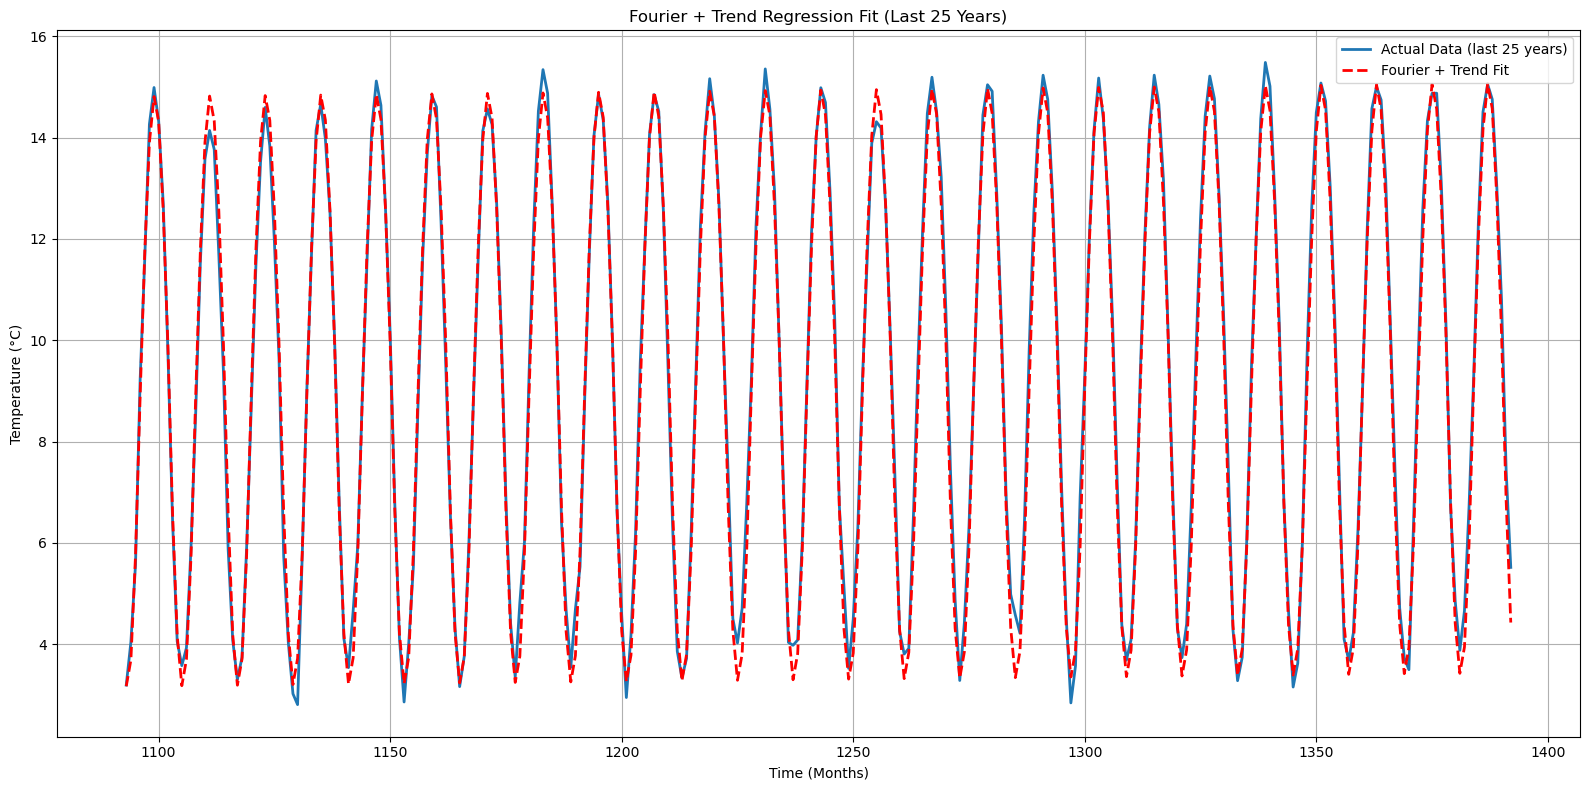

In [27]:
# Reconstruct y_hat from theta_hat
y_reg_fit = np.zeros(n)

for i in range(n):
    # Start with intercept + trend
    pred = theta_hat[0] + theta_hat[1] * t[i]

    # Add Fourier terms manually
    for k in range(1, K + 1):
        lam = 2 * np.pi * k / T
        pred += theta_hat[2 * k] * np.cos(lam * t[i]) + theta_hat[2 * k + 1] * np.sin(lam * t[i])

    y_reg_fit[i] = pred

#  Plot result
plt.figure(figsize=(16, 8))
plt.plot(t[-300:], y[-300:], label='Actual Data (last 25 years)', linewidth=2)
plt.plot(t[-300:], y_reg_fit[-300:], label='Fourier + Trend Fit', linestyle='--', linewidth=2, color='red')
plt.title('Fourier + Trend Regression Fit (Last 25 Years)')
plt.xlabel('Time (Months)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


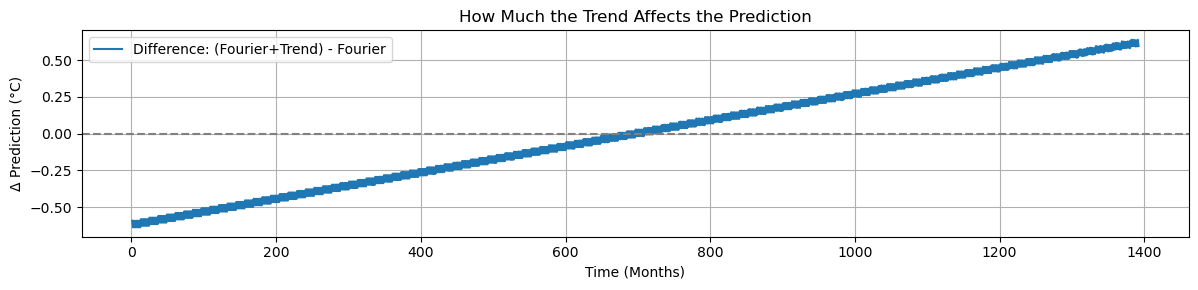

In [28]:
# Plot the difference between the two models (with and without trend)
plt.figure(figsize=(12, 3))
plt.plot(t, y_reg_fit - y_hat, label='Difference: (Fourier+Trend) - Fourier')
plt.axhline(0, color='gray', linestyle='--')
plt.title('How Much the Trend Affects the Prediction')
plt.xlabel('Time (Months)')
plt.ylabel('Δ Prediction (°C)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


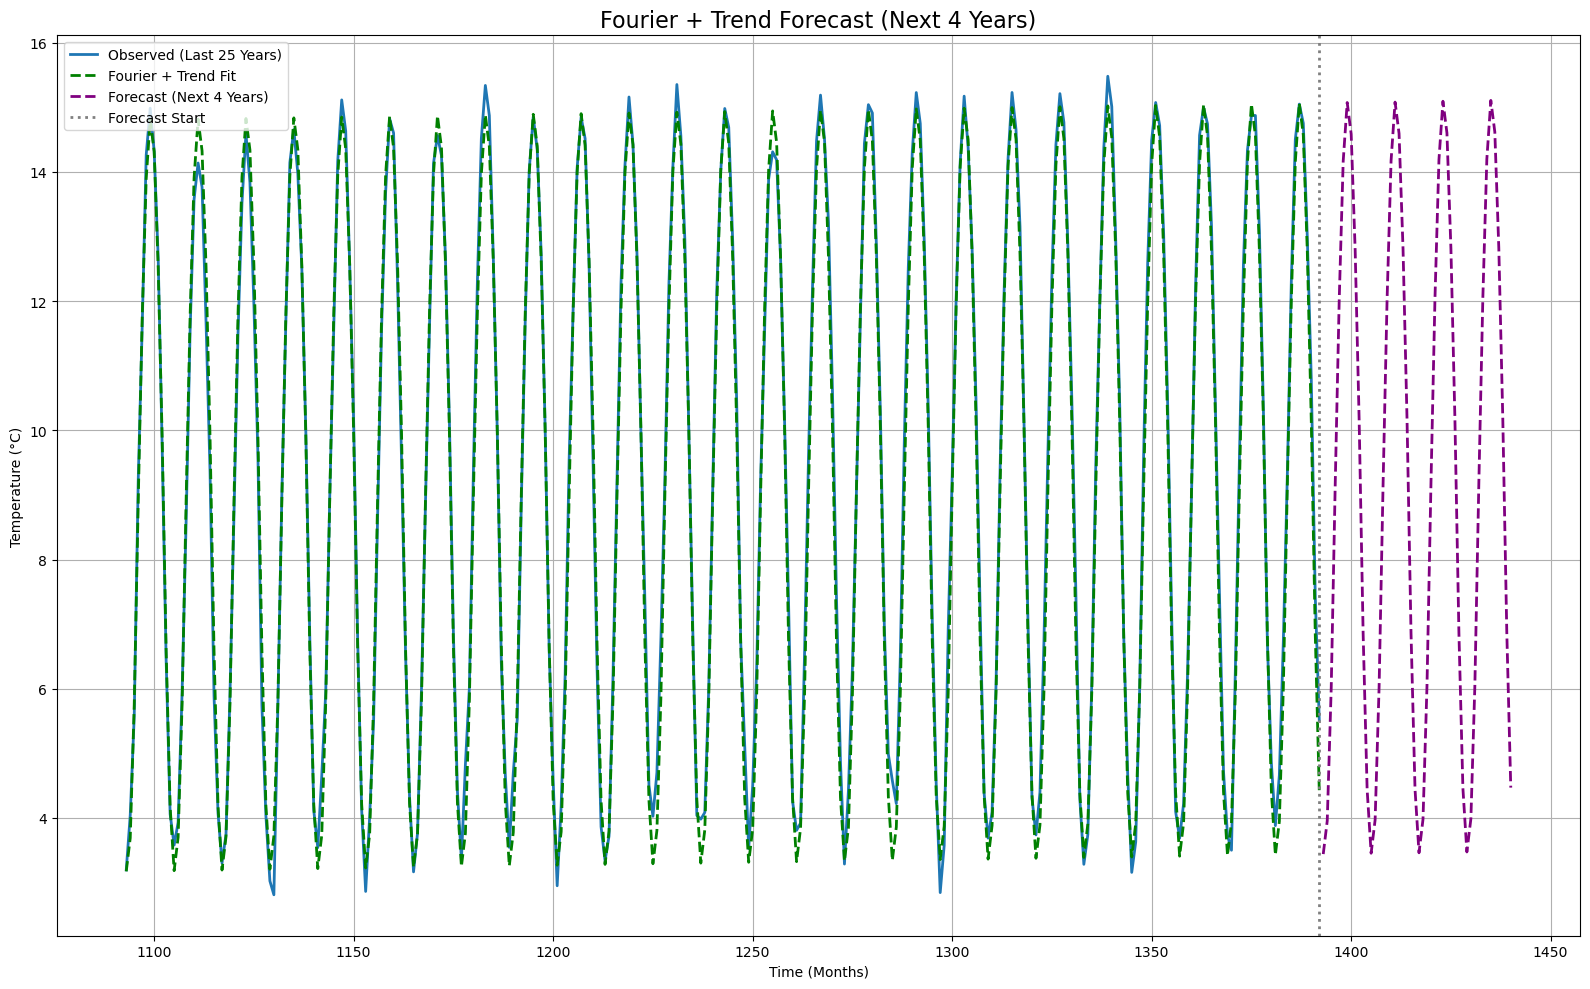

In [29]:
# Define future time steps
forecast_horizon = 48  # next 48 months
t_future = np.arange(n + 1, n + forecast_horizon + 1)

#  Forecast manually using theta_hat
y_future = np.zeros(forecast_horizon)

for i in range(forecast_horizon):
    t_val = t_future[i]
    pred = theta_hat[0] + theta_hat[1] * t_val
    for k in range(1, K + 1):
        lam = 2 * np.pi * k / T
        pred += theta_hat[2 * k] * np.cos(lam * t_val) + theta_hat[2 * k + 1] * np.sin(lam * t_val)
    y_future[i] = pred

#  Plot full model with forecast
plt.figure(figsize=(16, 10))
plt.plot(t[-300:], y[-300:], label='Observed (Last 25 Years)', linewidth=2)
plt.plot(t[-300:], y_reg_fit[-300:], label='Fourier + Trend Fit', linestyle='--', color='green', linewidth=2)
plt.plot(t_future, y_future, label='Forecast (Next 4 Years)', linestyle='--', color='purple', linewidth=2)

plt.axvline(x=n, color='gray', linestyle=':', linewidth=2, label='Forecast Start')
plt.title('Fourier + Trend Forecast (Next 4 Years)', fontsize=16)
plt.xlabel('Time (Months)')
plt.ylabel('Temperature (°C)')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


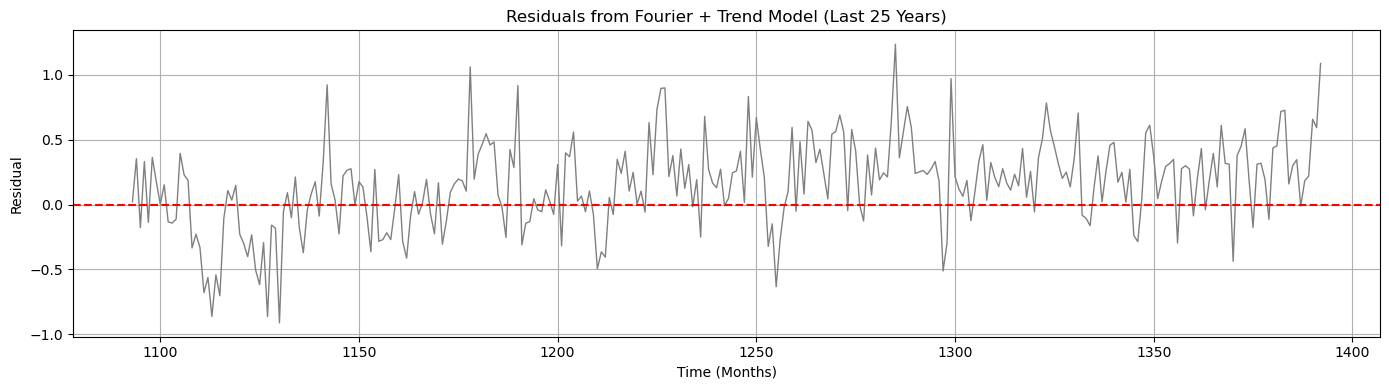

In [30]:
#  Calculate residuals from the fitted model
residuals = y - y_reg_fit  # Actual - Fitted

#  Plot residuals
plt.figure(figsize=(14, 4))
plt.plot(t[-300:], residuals[-300:], color='gray', linewidth=1)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals from Fourier + Trend Model (Last 25 Years)')
plt.xlabel('Time (Months)')
plt.ylabel('Residual')
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 600x600 with 0 Axes>

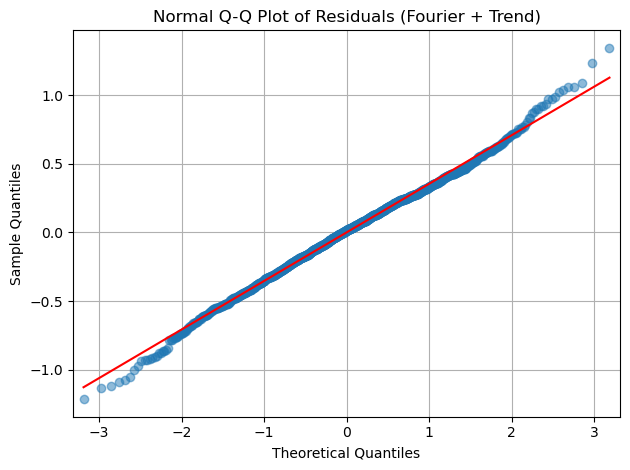

In [31]:
import scipy.stats as stats
# Q-Q Plot
plt.figure(figsize=(6, 6))
sm.qqplot(residuals, line='s', alpha=0.5)
plt.title("Normal Q-Q Plot of Residuals (Fourier + Trend)")
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1000x400 with 0 Axes>

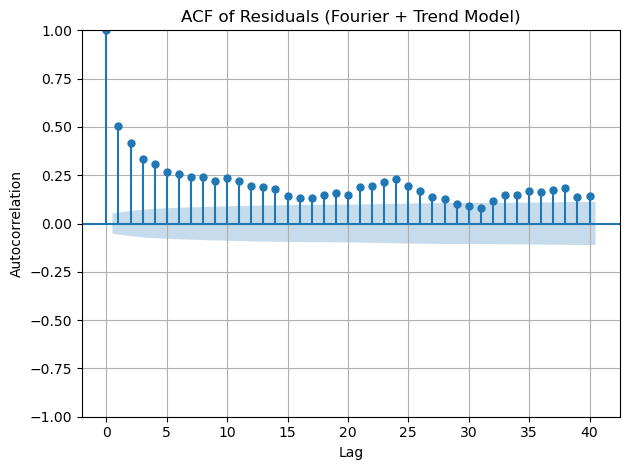

In [32]:
residuals = y - y_reg_fit  # Actual - Fitted
# ACF of residuals
plt.figure(figsize=(10, 4))
plot_acf(residuals, lags=40, alpha=0.05)
plt.title("ACF of Residuals (Fourier + Trend Model)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
# Prepare data for Prophet by renaming columns: 'ds' for dates and 'y' for the target variable
df_prophet = df[['LandAvgTemp']].copy()
df_prophet.reset_index(inplace=True)
df_prophet.rename(columns={'Date': 'ds', 'LandAvgTemp': 'y'}, inplace=True)
df_prophet.head()

ds       y
0 1900-01-01   1.461
1 1900-02-01   3.098
2 1900-03-01   5.492
3 1900-04-01   8.223
4 1900-05-01  11.385

In [34]:
# Initialize and fit the Prophet model
# We disable daily and weekly seasonality since our data is monthly, but enable yearly seasonality.
model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)
model.fit(df_prophet)

21:41:18 - cmdstanpy - INFO - Chain [1] start processing
21:41:18 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
# Create a future dataframe for forecasting the next 48 months (monthly frequency)
future = model.make_future_dataframe(periods=48, freq='MS')
forecast = model.predict(future)
forecast.head()

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 1900-01-01  8.350341    2.012283    2.840034     8.350341     8.350341   
1 1900-02-01  8.349045    2.554399    3.348124     8.349045     8.349045   
2 1900-03-01  8.347875    4.647835    5.421452     8.347875     8.347875   
3 1900-04-01  8.346580    7.755694    8.580457     8.346580     8.346580   
4 1900-05-01  8.345327   10.611552   11.405356     8.345327     8.345327   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -5.945124             -5.945124             -5.945124 -5.945124   
1       -5.388610             -5.388610             -5.388610 -5.388610   
2       -3.339127             -3.339127             -3.339127 -3.339127   
3       -0.198301             -0.198301             -0.198301 -0.198301   
4        2.657340              2.657340              2.657340  2.657340   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -5.945124     -5.945124                   0.0   
1     -5.388610     -5.388610                   0.0   
2     -3.339127     -3.339127                   0.0   
3     -0.198301     -0.198301                   0.0   
4      2.657340      2.657340                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper       yhat  
0                         0.0                         0.0   2.405217  
1                         0.0                         0.0   2.960436  
2                         0.0                         0.0   5.008748  
3                         0.0                         0.0   8.148279  
4                         0.0                         0.0  11.002666

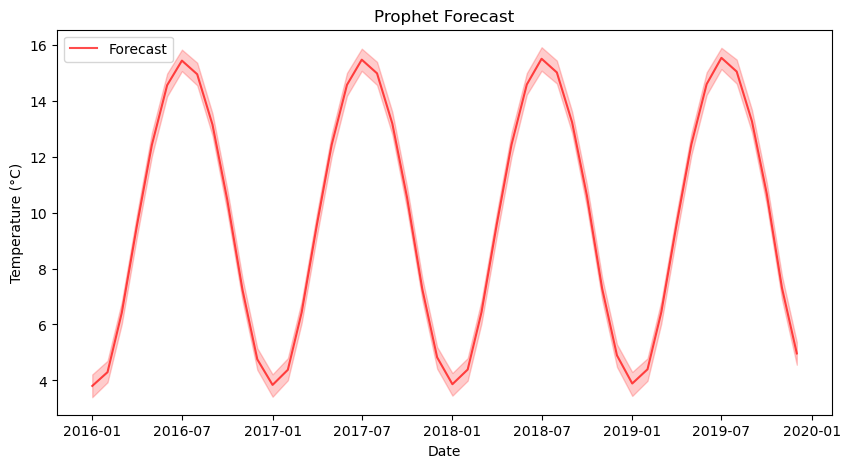

In [36]:
# Prophet Forecast (last 48 months)
plt.figure(figsize=(10, 5))
plt.plot(forecast['ds'][-48:], forecast['yhat'][-48:], label='Forecast', color='red', alpha=0.7)
plt.fill_between(forecast['ds'][-48:],
                 forecast['yhat_lower'][-48:],
                 forecast['yhat_upper'][-48:],
                 color='red', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Prophet Forecast')
plt.legend()
plt.show()

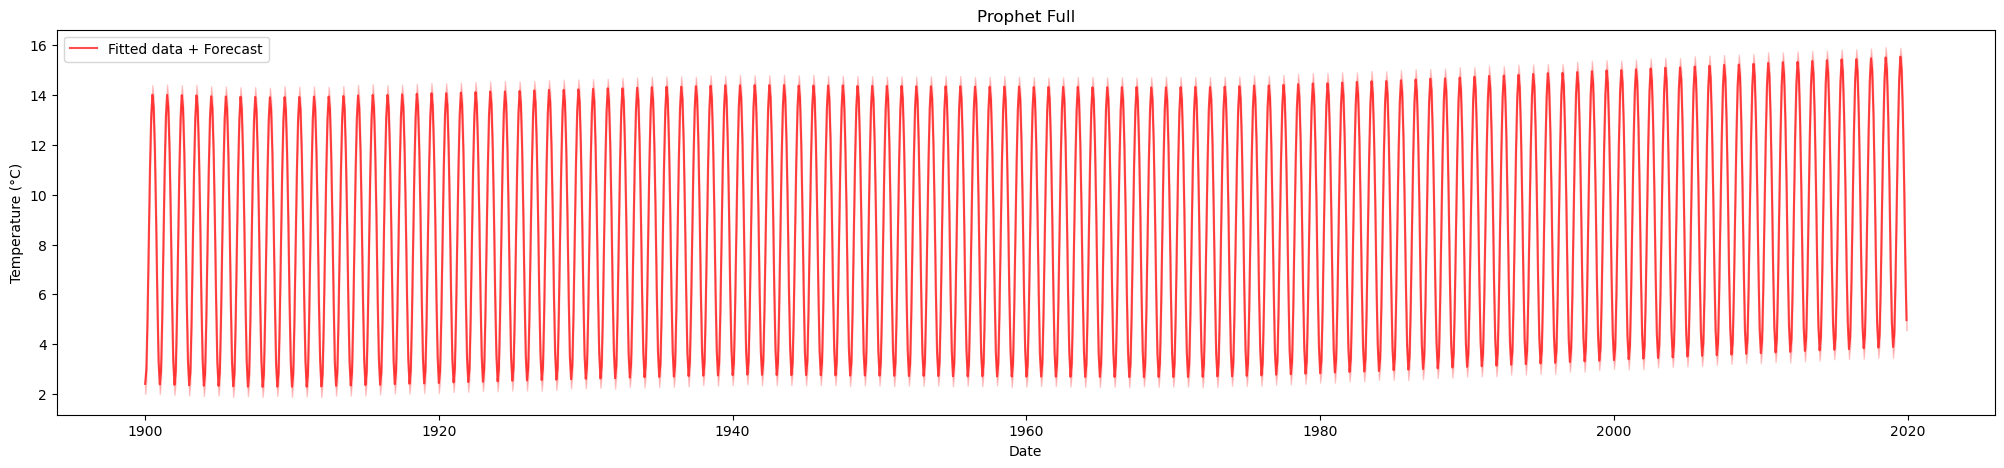

In [37]:
# Prophet Full (entire fitted data + forecast)
plt.figure(figsize=(25, 5))
plt.plot(forecast['ds'], forecast['yhat'], label='Fitted data + Forecast', color='red', alpha=0.7)
plt.fill_between(forecast['ds'],
                 forecast['yhat_lower'],
                 forecast['yhat_upper'],
                 color='red', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Prophet Full')
plt.legend()
plt.show()

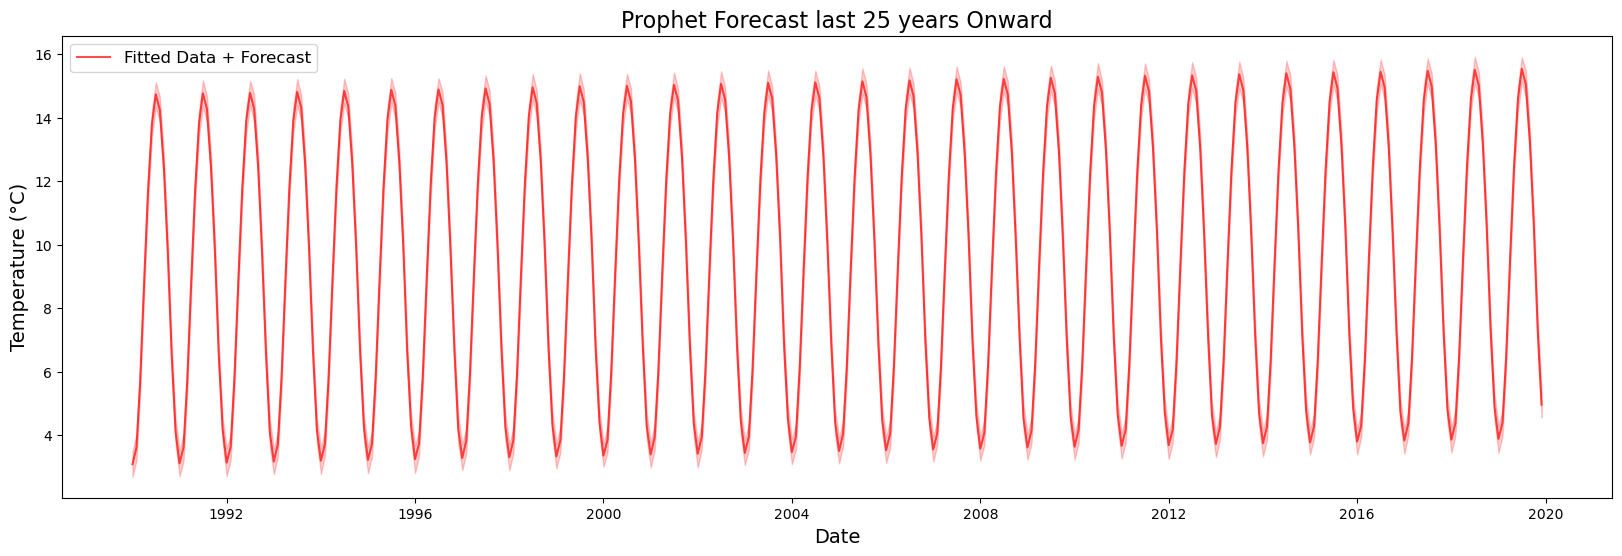

In [38]:
# Subset the forecast DataFrame to include dates from 2000 onward
forecast_subset = forecast[forecast['ds'] >= '1990-01-01']

# Plot the forecast (fitted data + forecast) from 2000 onward
plt.figure(figsize=(20, 6))
plt.plot(forecast_subset['ds'], forecast_subset['yhat'], label='Fitted Data + Forecast', color='red', alpha=0.7)
plt.fill_between(forecast_subset['ds'],
                 forecast_subset['yhat_lower'],
                 forecast_subset['yhat_upper'],
                 color='red', alpha=0.2)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.title('Prophet Forecast last 25 years Onward', fontsize=16)
plt.legend(fontsize=12)
plt.show()

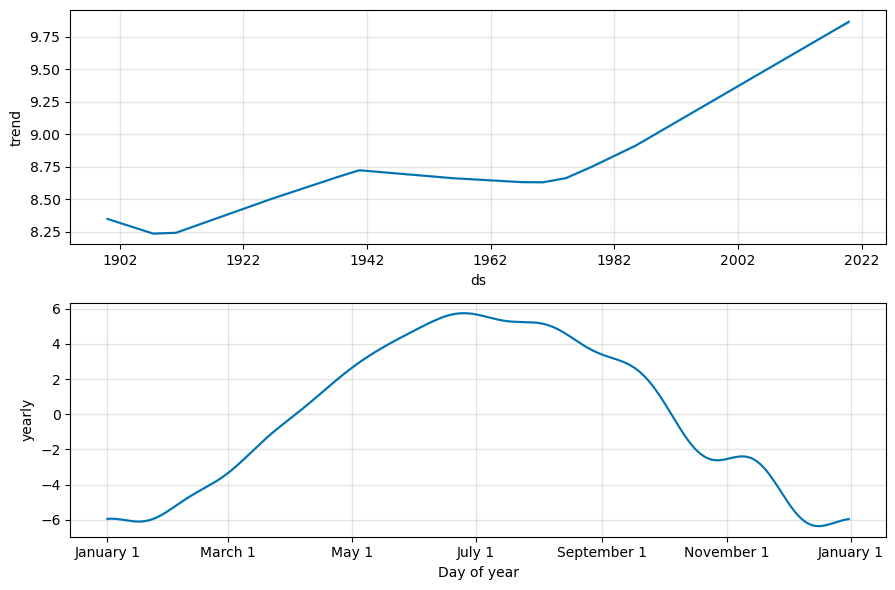

In [39]:
# Plot the forecast components: trend, yearly seasonality, etc.
fig2 = model.plot_components(forecast)
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
21:41:29 - cmdstanpy - INFO - Chain [1] start processing
21:41:30 - cmdstanpy - INFO - Chain [1] done processing


MSE     MAE    RMSE
SARIMA           0.0873  0.2187  0.2955
Fourier + Trend  0.1687  0.3490  0.4107
Prophet          0.0913  0.2314  0.3021

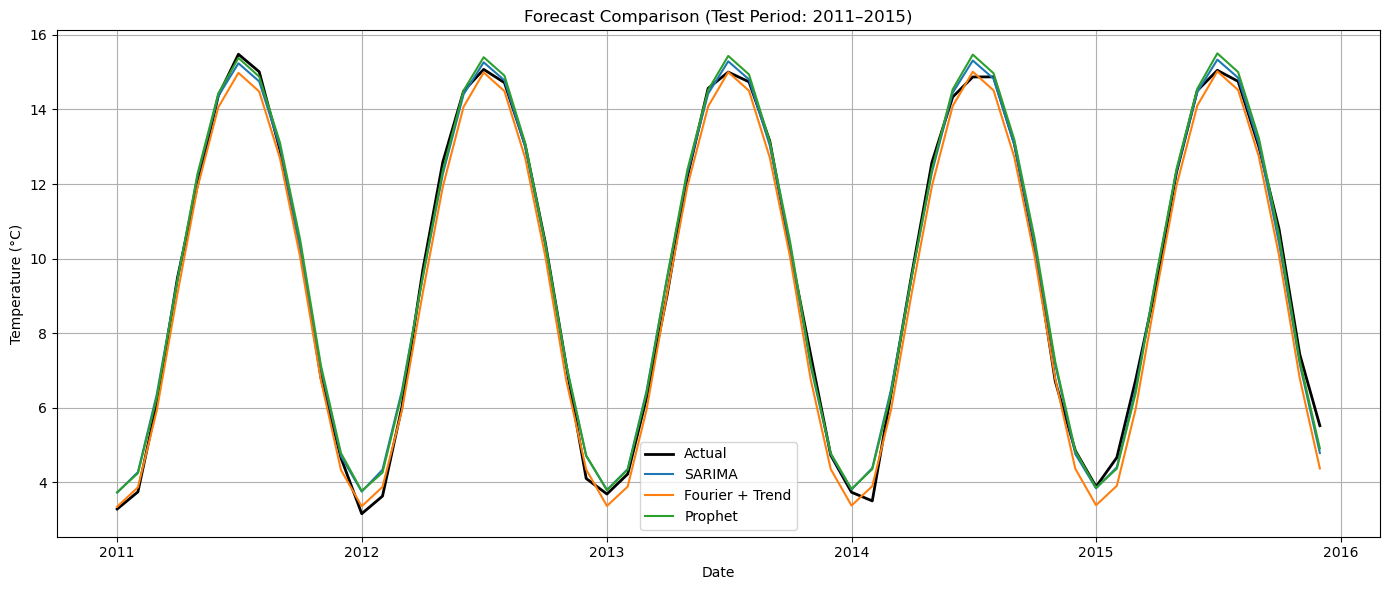

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error



train_end = '2010-12-01'
test_start = '2011-01-01'
test_end = '2015-12-01'

y_train = df['LandAvgTemp'].loc[:train_end]
y_test = df['LandAvgTemp'].loc[test_start:test_end]

#  SARIMA Model
sarima_model = SARIMAX(y_train,
                       order=(1, 1, 2),
                       seasonal_order=(1, 1, 2, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)
sarima_forecast = sarima_result.get_forecast(steps=60).predicted_mean.values


#  Fourier + Trend
t_train = np.arange(len(y_train)) + 1
t_test = np.arange(len(y_train)+1, len(y_train)+61)
y_fit = y_train.values
T = 12
K = 6  # harmonics

# Design matrix for training
X_train = np.column_stack([np.ones_like(t_train), t_train])
for k in range(1, K + 1):
    lam = 2 * np.pi * k / T
    X_train = np.column_stack((X_train,
                               np.cos(lam * t_train),
                               np.sin(lam * t_train)))

theta_hat = np.linalg.lstsq(X_train, y_fit, rcond=None)[0]

# Design matrix for testing
X_test = np.column_stack([np.ones_like(t_test), t_test])
for k in range(1, K + 1):
    lam = 2 * np.pi * k / T
    X_test = np.column_stack((X_test,
                              np.cos(lam * t_test),
                              np.sin(lam * t_test)))

fourier_forecast = X_test @ theta_hat


# Prophet Model
prophet_df = y_train.reset_index()
prophet_df.columns = ['ds', 'y']
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
prophet_model.fit(prophet_df)

future = prophet_model.make_future_dataframe(periods=60, freq='MS')
prophet_forecast_df = prophet_model.predict(future)
prophet_pred = prophet_forecast_df.loc[future['ds'] >= test_start].set_index('ds').loc[test_start:test_end]['yhat'].values


#  Metrics

y_true = y_test.values
results = {}
for model_name, pred in zip(
    ['SARIMA', 'Fourier + Trend', 'Prophet'],
    [sarima_forecast, fourier_forecast, prophet_pred]
):
    mse = mean_squared_error(y_true, pred)
    mae = mean_absolute_error(y_true, pred)
    rmse = np.sqrt(mse)
    results[model_name] = {'MSE': mse, 'MAE': mae, 'RMSE': rmse}

results_df = pd.DataFrame(results).T.round(4)


# : Display + Plot
import IPython.display as disp
disp.display(results_df)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_true, label='Actual', color='black', linewidth=2)
plt.plot(y_test.index, sarima_forecast, label='SARIMA')
plt.plot(y_test.index, fourier_forecast, label='Fourier + Trend')
plt.plot(y_test.index, prophet_pred, label='Prophet')
plt.title("Forecast Comparison (Test Period: 2011–2015)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **part 3 :**

In [41]:

df = pd.read_csv('mixed_dataset.csv', dtype=str)

#  Rename columns ===
df.rename(columns={
    'dt': 'Date',
    'LandAverageTemperature': 'LandAvgTemp'
}, inplace=True)

#  Parse the two known date formats 
# Format A: YYYY-MM-DD (before 1900)
df_iso = df[df['Date'].str.contains(r'\d{4}-\d{2}-\d{2}', na=False)].copy()
df_iso['Date'] = pd.to_datetime(df_iso['Date'], format='%Y-%m-%d', errors='coerce')

# Format B: DD/MM/YYYY (after 1900)
df_dmy = df[~df.index.isin(df_iso.index)].copy()
df_dmy['Date'] = pd.to_datetime(df_dmy['Date'], format='%d/%m/%Y', errors='coerce')

#  Combine both parsed subsets 
df = pd.concat([df_iso, df_dmy])

# Clean and prepare 
df.dropna(subset=['Date'], inplace=True)
df = df[df['Date'] >= '1900-01-01']
df['LandAvgTemp'] = pd.to_numeric(df['LandAvgTemp'], errors='coerce')
df.dropna(subset=['LandAvgTemp'], inplace=True)
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

#  Extract 1979–2015 period and CO₂ trend 
df = df.reset_index()
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df = df[(df['year'] >= 1979) & (df['year'] <= 2015)]

#  Rename CO₂ column and finalize structure 
df = df.rename(columns={'CO2_Trend': 'trend'})
merged_df = df[['Date', 'LandAvgTemp', 'trend']].copy()
merged_df.sort_values(by='Date', inplace=True)
merged_df.reset_index(drop=True, inplace=True)

# Preview
print(merged_df.head())
print(merged_df.tail())
print(f"Total rows: {len(merged_df)}")

        Date  LandAvgTemp   trend
0 1979-01-01        2.679  335.92
1 1979-02-01        2.841  336.26
2 1979-03-01        5.474  336.51
3 1979-04-01        8.455  336.72
4 1979-05-01       11.199  336.71
          Date  LandAvgTemp   trend
439 2015-08-01       14.755  399.85
440 2015-09-01       12.999  400.14
441 2015-10-01       10.801  400.37
442 2015-11-01        7.433  400.68
443 2015-12-01        5.518  401.17
Total rows: 444


In [42]:
# : Extract target and features from merged_df
y = merged_df['LandAvgTemp'].values
n = len(y)
T = 12  # Monthly seasonality
K = 6   # Number of harmonics

#Create time index
t = np.arange(1, n + 1)

# Create Fourier + time + exogenous matrix
X = []

for i in range(n):
    row = [1, t[i]]  # Intercept + linear trend
    for k in range(1, K + 1):
        lam = 2 * np.pi * k / T
        row.append(np.cos(lam * t[i]))
        row.append(np.sin(lam * t[i]))
    row.append(merged_df['trend'].iloc[i])  # Add exogenous CO₂ trend
    X.append(row)

X = np.array(X, dtype=np.float64)

# Preview shape
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (444, 15)
y shape: (444,)


In [43]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define model names and dictionary
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'SVR': SVR(kernel='linear'),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42)
}

#  Fit and evaluate models
model_results = {}
mse_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_results[name] = y_pred
    mse_results[name] = mean_squared_error(y_test, y_pred)
mse_df = pd.DataFrame.from_dict(mse_results, orient='index', columns=['MSE']).sort_values(by='MSE')
print("Mean Squared Error for each model:")
print(mse_df)

Mean Squared Error for each model:
                   MSE
RandomForest  0.107311
XGBoost       0.140291
Linear        0.177378
Ridge         0.178538
SVR           0.246569
DecisionTree  0.259425
Lasso         4.339406


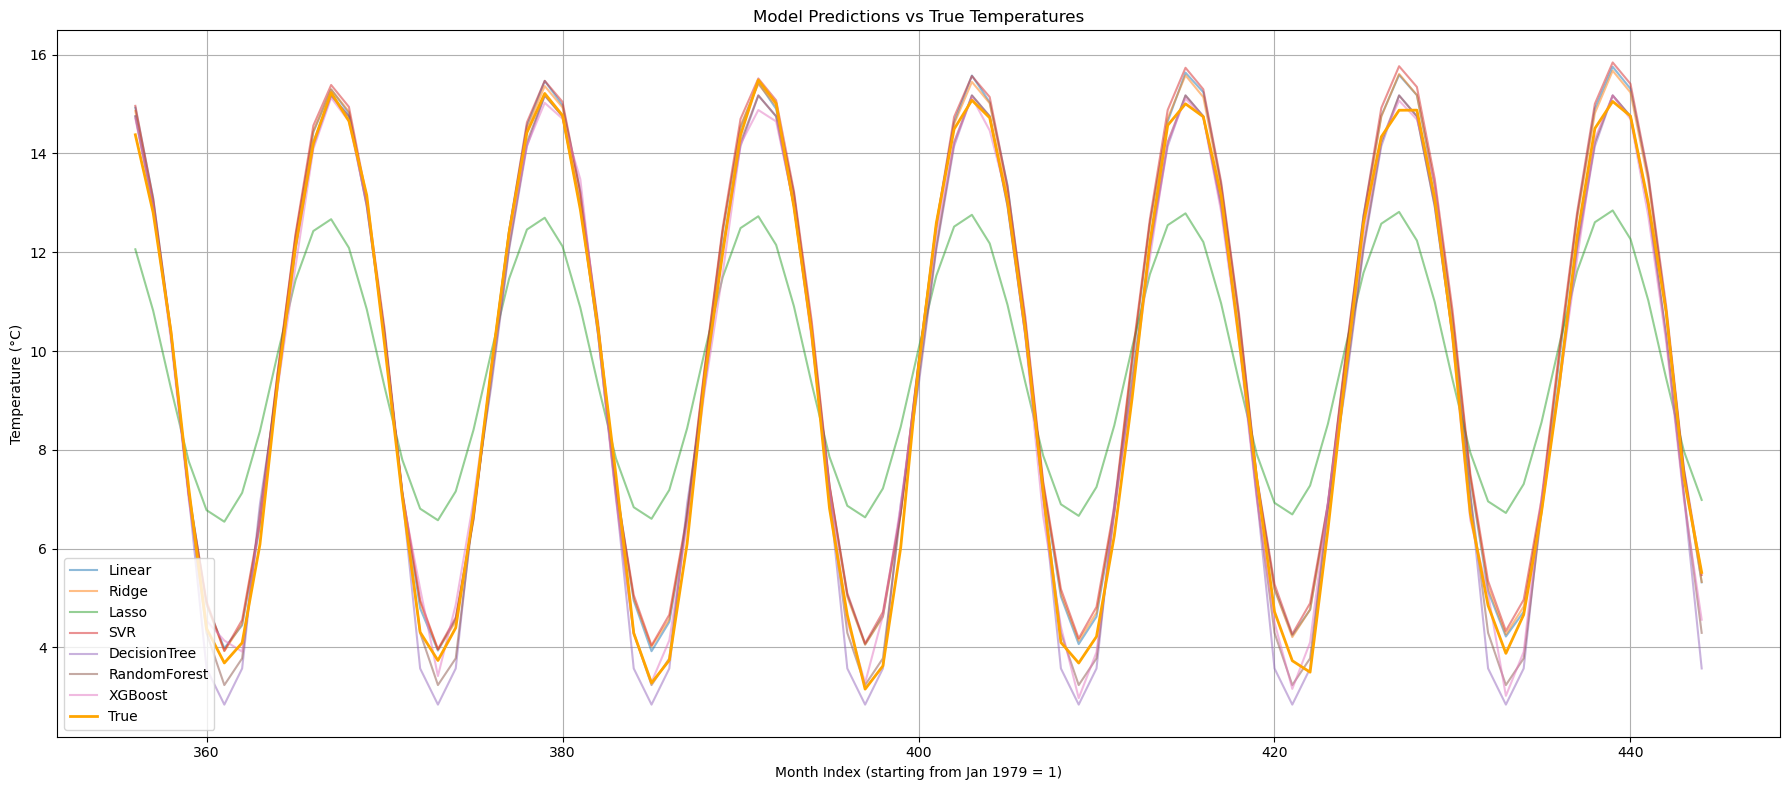

In [44]:
import matplotlib.pyplot as plt
import numpy as np

#  Compute absolute time index for all months
t = np.arange(1, len(y) + 1)  # Full series: t = 1 to n

# Extract t for the test set
t_test = t[-len(y_test):]  # This will be like 152 to 444

#  Plot using t_test as x-axis
def plot_preds(y_preds, y_true, title, x_vals):
    plt.figure(figsize=(18, 8))
    for model_name, y_pred in y_preds.items():
        plt.plot(x_vals, y_pred, label=model_name, alpha=0.5)
    plt.plot(x_vals, y_true, label='True', color='orange', linewidth=2)
    plt.xlabel('Month Index (starting from Jan 1979 = 1)')
    plt.ylabel('Temperature (°C)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#  Call the function
plot_preds(model_results, y_test, "Model Predictions vs True Temperatures", t_test)


In [47]:
#  Create X_future for forecasting ===

forecast_horizon = 48  # Forecasting 4 years ahead
T = 12                 # Monthly seasonality
K = 6                  # Number of harmonics

# Time index for future months
t_last = len(y)  # Last time index from full data
t_future = np.arange(t_last + 1, t_last + forecast_horizon + 1)

merged_df['trend'] = pd.to_numeric(merged_df['trend'], errors='coerce')
merged_df.dropna(subset=['trend'], inplace=True)
# Extrapolate CO₂ trend linearly
last_trend = merged_df['trend'].iloc[-1]
second_last_trend = merged_df['trend'].iloc[-2]
slope = last_trend - second_last_trend
trend_future = [last_trend + slope * (i + 1) for i in range(forecast_horizon)]

# Build X_future with same structure
X_future = []
for i in range(forecast_horizon):
    row = [1, t_future[i]]  # Intercept + trend
    for k in range(1, K + 1):
        lam = 2 * np.pi * k / T
        row.append(np.cos(lam * t_future[i]))
        row.append(np.sin(lam * t_future[i]))
    row.append(trend_future[i])  # CO₂ trend
    X_future.append(row)

X_future = np.array(X_future)
print("X_future shape:", X_future.shape)


X_future shape: (48, 15)


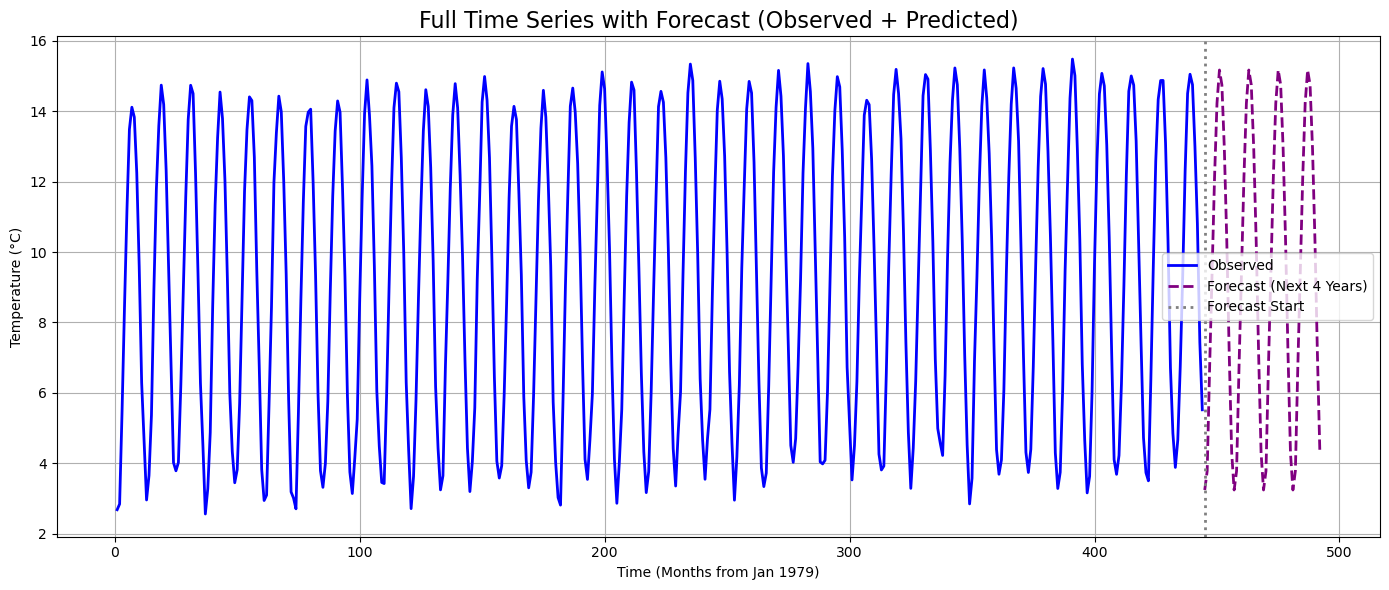

In [48]:
#  Forecast with best model 
best_model = models['RandomForest']  # or 'XGBoost', etc.
y_future = best_model.predict(X_future)

#  Combine full y (real) with forecast 
y_combined = np.concatenate([y, y_future])

#  Create time axis (months from 1 to total length) 
t_combined = np.arange(1, len(y_combined) + 1)
forecast_start = len(y) + 1  # where forecast begins

#  Plot full data with forecast 
plt.figure(figsize=(14, 6))
plt.plot(t_combined[:len(y)], y, label='Observed', color='blue', linewidth=2)
plt.plot(t_combined[len(y):], y_future, label='Forecast (Next 4 Years)', color='purple', linestyle='--', linewidth=2)
plt.axvline(x=forecast_start, color='gray', linestyle=':', linewidth=2, label='Forecast Start')

plt.title('Full Time Series with Forecast (Observed + Predicted)', fontsize=16)
plt.xlabel('Time (Months from Jan 1979)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

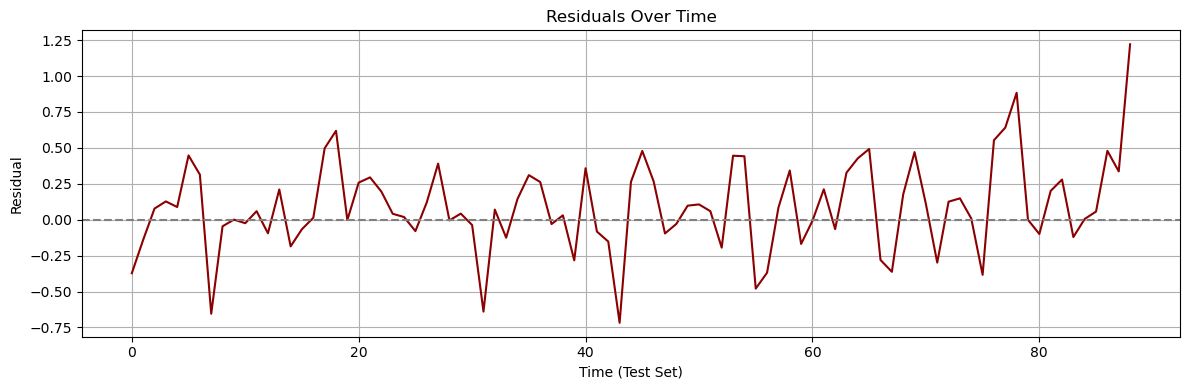

In [49]:
# Get residuals from test set
y_pred_test = model_results['RandomForest']  # use 'Linear' or others if needed
residuals = y_test - y_pred_test

#  Plot residuals over time
plt.figure(figsize=(12, 4))
plt.plot(residuals, label='Residuals', color='darkred')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Time (Test Set)')
plt.ylabel('Residual')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 800x400 with 0 Axes>

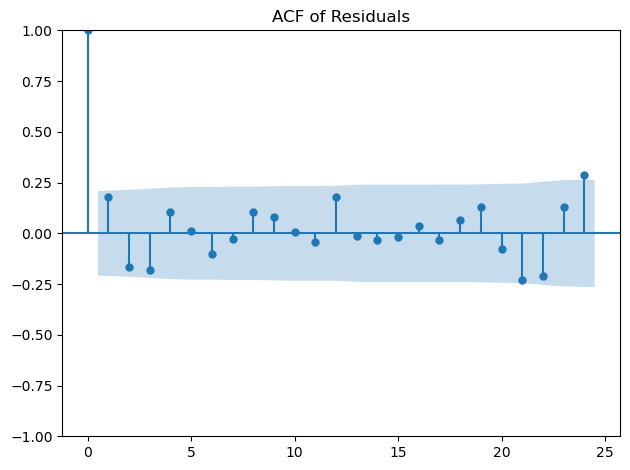

In [50]:
# ACF plot of residuals
plt.figure(figsize=(8, 4))
plot_acf(residuals, lags=24)
plt.title("ACF of Residuals")
plt.tight_layout()
plt.show()

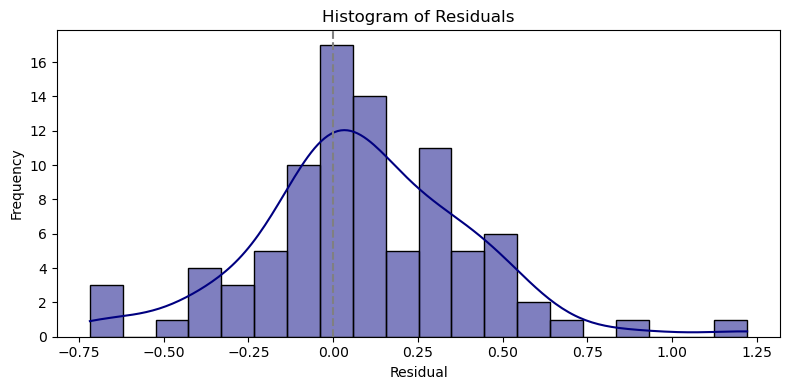

In [51]:
# Histogram + KDE
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, color='navy', bins=20)
plt.axvline(0, color='gray', linestyle='--')
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

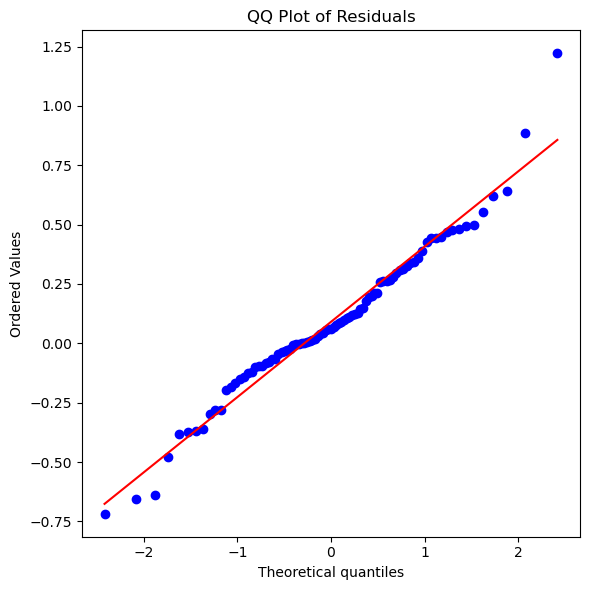

In [52]:
# QQ Plot
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.tight_layout()
plt.show()

In [53]:
# Mean of residuals
print("Mean of residuals:", np.mean(residuals))

Mean of residuals: 0.09037078651685904


In [54]:
# Create X_no_exog (no CO₂ trend)

X_no_exog = []

for i in range(len(y)):
    row = [1, t[i]]  # Intercept + time
    for k in range(1, K + 1):
        lam = 2 * np.pi * k / T
        row.append(np.cos(lam * t[i]))
        row.append(np.sin(lam * t[i]))
    X_no_exog.append(row)

X_no_exog = np.array(X_no_exog)

print("Shape of X_no_exog:", X_no_exog.shape)


Shape of X_no_exog: (444, 14)


In [55]:
#  Split again (same way)
Xn_train, Xn_test = X_no_exog[:len(X_train)], X_no_exog[len(X_train):]

# Train same models
models_no_exog = {
    'Linear': LinearRegression(),
    'RandomForest': RandomForestRegressor()
}

mse_no_exog = {}

for name, model in models_no_exog.items():
    model.fit(Xn_train, y_train)
    y_pred = model.predict(Xn_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_no_exog[name] = mse

In [56]:
#  Compare with and without trend
mse_with_trend = {
    'Linear': mean_squared_error(y_test, model_results['Linear']),
    'RandomForest': mean_squared_error(y_test, model_results['RandomForest'])
}

# Combine into a table
comparison_df = pd.DataFrame({
    'With CO₂ Trend': mse_with_trend,
    'Without CO₂ Trend': mse_no_exog
})

print("MSE Comparison (With vs. Without Exogenous Variable):")
print(comparison_df)

MSE Comparison (With vs. Without Exogenous Variable):
              With CO₂ Trend  Without CO₂ Trend
Linear              0.177378           0.083046
RandomForest        0.107311           0.097738


In [57]:
#Function to compute BIC for Linear Regression
def compute_bic(y_true, y_pred, num_params):
    n = len(y_true)
    rss = np.sum((y_true - y_pred) ** 2)
    bic = n * np.log(rss / n) + num_params * np.log(n)
    return bic

# Number of parameters (intercept + coefficients)
k_with = X_train.shape[1] + 1
k_without = Xn_train.shape[1] + 1

# Refit models to make sure predictions are aligned
linear_with = LinearRegression()
linear_with.fit(X_train, y_train)
y_pred_with = linear_with.predict(X_test)

linear_no_exog = LinearRegression()
linear_no_exog.fit(Xn_train, y_train)
y_pred_without = linear_no_exog.predict(Xn_test)

# Compute BICs
bic_with = compute_bic(y_test, y_pred_with, k_with)
bic_without = compute_bic(y_test, y_pred_without, k_without)

print("BIC Comparison (Linear Regression)")
print(f"With CO₂ trend     : {bic_with:.2f}")
print(f"Without CO₂ trend  : {bic_without:.2f}")

BIC Comparison (Linear Regression)
With CO₂ trend     : -82.10
Without CO₂ trend  : -154.13


In [58]:
# Make sure you're using the merged dataset from 1979 to 2015
corr = merged_df[['LandAvgTemp', 'trend']].corr()
print("Correlation between Temperature and CO₂ Trend:")
print(corr)

Correlation between Temperature and CO₂ Trend:
             LandAvgTemp     trend
LandAvgTemp     1.000000  0.076056
trend           0.076056  1.000000


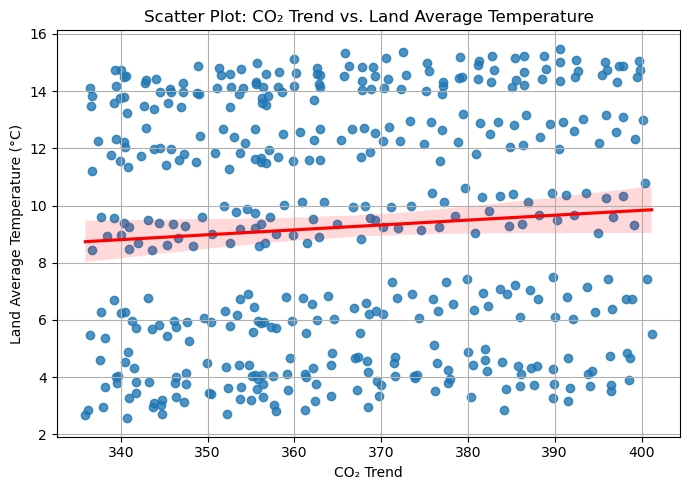

In [59]:
plt.figure(figsize=(7, 5))
sns.regplot(data=merged_df, x='trend', y='LandAvgTemp', line_kws={'color': 'red'})
plt.title("Scatter Plot: CO₂ Trend vs. Land Average Temperature")
plt.xlabel("CO₂ Trend")
plt.ylabel("Land Average Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [60]:
from sklearn.metrics import mean_absolute_error
# Ensure you're using predictions from consistent splits:
# Refit Linear WITH trend
linear_with = LinearRegression()
linear_with.fit(X_train, y_train)
y_pred_with = linear_with.predict(X_test)

# Refit Linear WITHOUT trend
linear_no_exog = LinearRegression()
linear_no_exog.fit(Xn_train, y_train)
y_pred_without = linear_no_exog.predict(Xn_test)

# Calculate MAE
mae_with = mean_absolute_error(y_test, y_pred_with)
mae_without = mean_absolute_error(y_test, y_pred_without)

# Print comparison
print("MAE Comparison (Linear Regression)")
print(f"With CO₂ trend     : {mae_with:.4f}")
print(f"Without CO₂ trend  : {mae_without:.4f}")

MAE Comparison (Linear Regression)
With CO₂ trend     : 0.3375
Without CO₂ trend  : 0.2187


In [61]:
#  Get existing predictions
y_pred_rf_with = model_results['RandomForest']                     # With CO₂
y_pred_rf_without = models_no_exog['RandomForest'].predict(Xn_test)  # Without CO₂

#  Compute MAE
mae_rf_with = mean_absolute_error(y_test, y_pred_rf_with)
mae_rf_without = mean_absolute_error(y_test, y_pred_rf_without)

#  Display results
print("MAE Comparison (Random Forest)")
print(f"With CO₂ trend     : {mae_rf_with:.4f}")
print(f"Without CO₂ trend  : {mae_rf_without:.4f}")

MAE Comparison (Random Forest)
With CO₂ trend     : 0.2408
Without CO₂ trend  : 0.2346


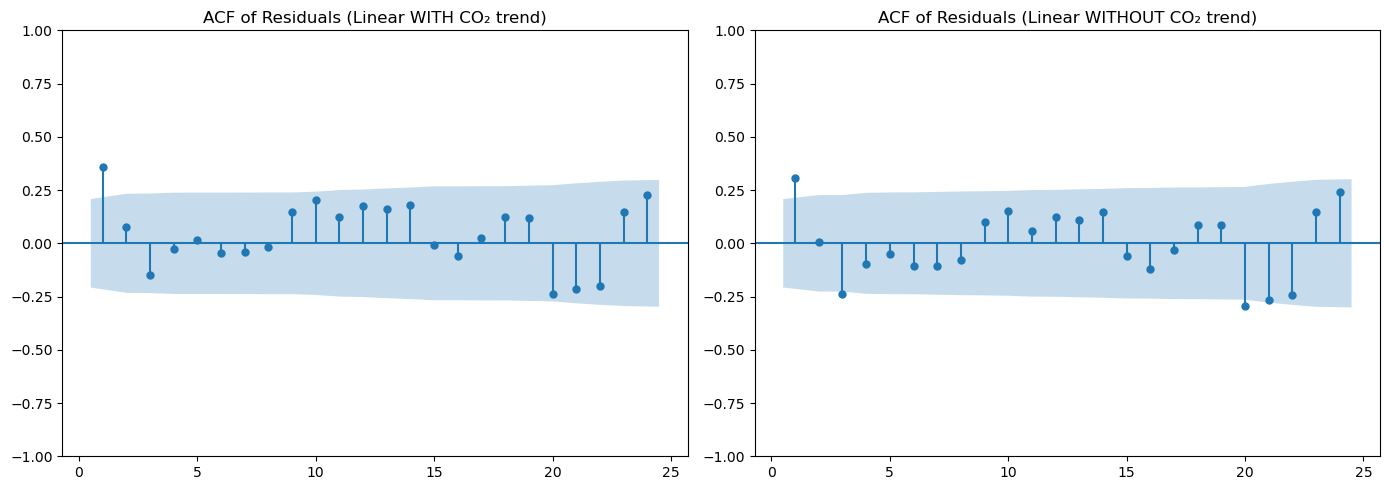

In [62]:
# Refit Linear WITH CO₂ trend
linear_with = LinearRegression()
linear_with.fit(X_train, y_train)
y_pred_with = linear_with.predict(X_test)
residuals_with = y_test - y_pred_with

# Refit Linear WITHOUT CO₂ trend 
linear_no_exog = LinearRegression()
linear_no_exog.fit(Xn_train, y_train)
y_pred_without = linear_no_exog.predict(Xn_test)
residuals_without = y_test - y_pred_without

# Plot ACF side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(residuals_with, lags=24, zero=False, ax=axes[0])
axes[0].set_title("ACF of Residuals (Linear WITH CO₂ trend)")

plot_acf(residuals_without, lags=24, zero=False, ax=axes[1])
axes[1].set_title("ACF of Residuals (Linear WITHOUT CO₂ trend)")

plt.tight_layout()
plt.show()

# part 4:

<Figure size 1000x400 with 0 Axes>

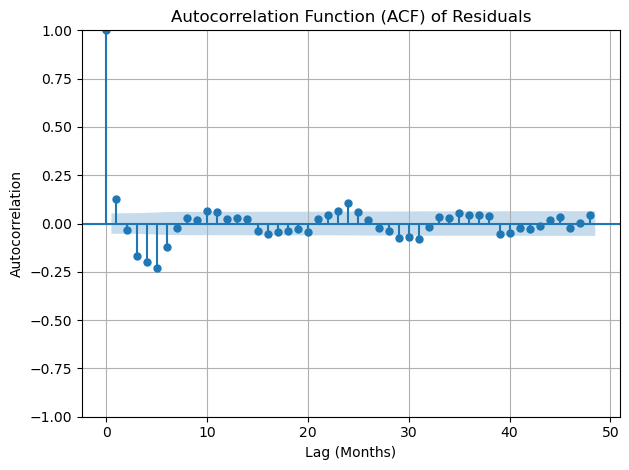

In [63]:
residual = aligned_data - aligned_trend - seasonality
# Plot the ACF of the residuals
plt.figure(figsize=(10, 4))
plot_acf(residual, lags=48)
plt.title("Autocorrelation Function (ACF) of Residuals")
plt.xlabel("Lag (Months)")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.tight_layout()
plt.show()

In [64]:
#  Split residual into 12 monthly series and align by year

# Create a dictionary to hold months (1=Jan, ..., 12=Dec)
residual_months = {i: [] for i in range(1, 13)}

# Group residuals by month
for date, value in residual.items():
    month = date.month
    residual_months[month].append((date, value))

# Convert each month's data into a time series
residual_month_dfs = {}
for month in range(1, 13):
    data = residual_months[month]
    dates_m, values = zip(*data)
    series = pd.Series(data=values, index=pd.to_datetime(dates_m)).sort_index()
    residual_month_dfs[month] = series

# Identify years present in all months
years_by_month = [set(df.index.year) for df in residual_month_dfs.values()]
common_years = sorted(set.intersection(*years_by_month))

# Filter each series to only keep those years
for month in residual_month_dfs:
    df = residual_month_dfs[month]
    residual_month_dfs[month] = df[df.index.year.isin(common_years)]

    # Debug print
    print(f"Month {month}: {len(residual_month_dfs[month])} entries")
    print(f"   Years: {residual_month_dfs[month].index.year.min()} to {residual_month_dfs[month].index.year.max()}")


print(f"Residual series split into 12 monthly groups with {len(common_years)} common years.")


Month 1: 114 entries
   Years: 1901 to 2014
Month 2: 114 entries
   Years: 1901 to 2014
Month 3: 114 entries
   Years: 1901 to 2014
Month 4: 114 entries
   Years: 1901 to 2014
Month 5: 114 entries
   Years: 1901 to 2014
Month 6: 114 entries
   Years: 1901 to 2014
Month 7: 114 entries
   Years: 1901 to 2014
Month 8: 114 entries
   Years: 1901 to 2014
Month 9: 114 entries
   Years: 1901 to 2014
Month 10: 114 entries
   Years: 1901 to 2014
Month 11: 114 entries
   Years: 1901 to 2014
Month 12: 114 entries
   Years: 1901 to 2014
Residual series split into 12 monthly groups with 114 common years.


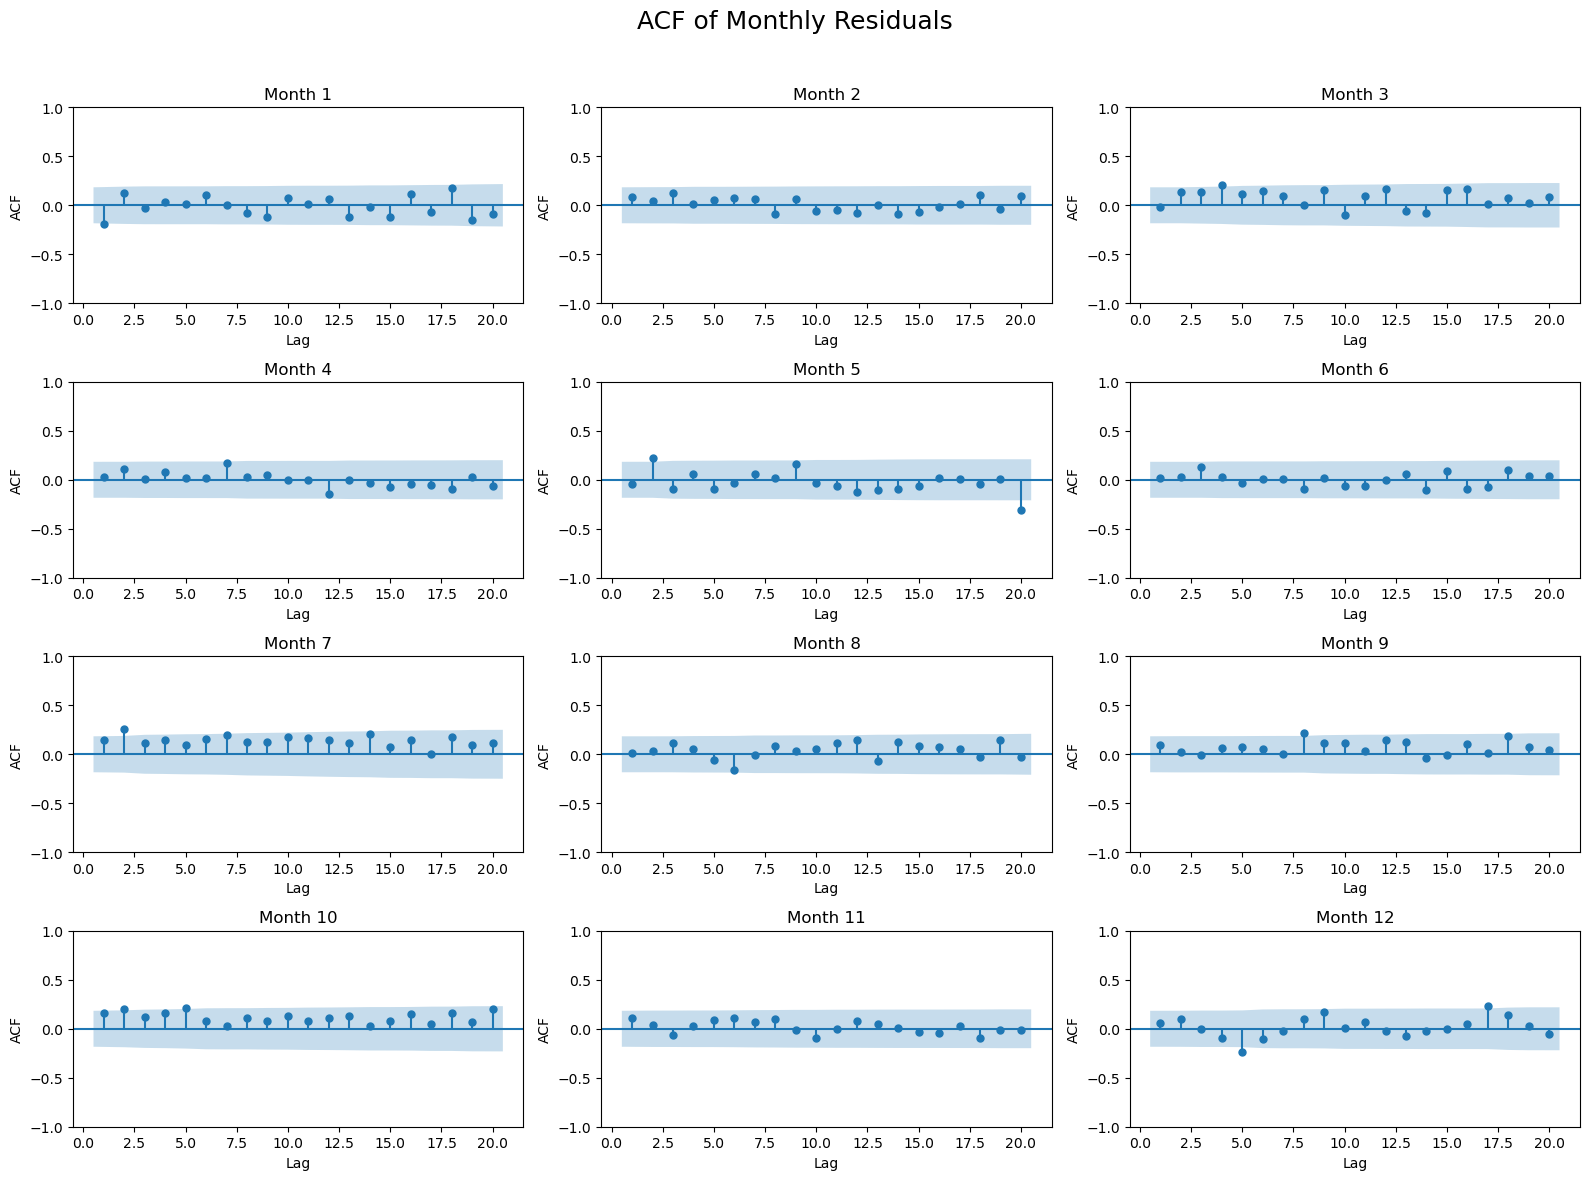

In [65]:
# Plot ACF for each month's residuals
fig, axes = plt.subplots(4, 3, figsize=(16, 12))  # 12 subplots: 4 rows × 3 columns
fig.suptitle("ACF of Monthly Residuals", fontsize=18)

for month, ax in zip(range(1, 13), axes.flatten()):
    series = residual_month_dfs[month]
    plot_acf(series, ax=ax, lags=20, zero=False, title=f"Month {month}", alpha=0.05)
    ax.set_xlabel("Lag")
    ax.set_ylabel("ACF")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [66]:
# Suggest CUSUM parameters (k, h) per month based on monthly residual std

cusum_params_by_month = {}

print("Suggested CUSUM parameters per month:\n")
print(f"{'Month':^7} | {'σ':^8} | {'Δ = 0.4σ':^10} | {'k = Δ/2':^9} | {'log(B)':^9}")
print("-" * 50)

for month in range(1, 13):
    series = residual_month_dfs[month]
    sigma = series.std()
    delta = 0.4 * sigma
    k = delta / 2
    h = 5 * sigma
    logB = np.log(h)  #  use log threshold instead

    cusum_params_by_month[month] = {'sigma': sigma, 'k': k, 'logB': logB}

    print(f"{month:^7} | {sigma:.5f} | {delta:.5f}   | {k:.5f}  | {logB:.5f}")


Suggested CUSUM parameters per month:

 Month  |    σ     |  Δ = 0.4σ  |  k = Δ/2  |  log(B)  
--------------------------------------------------
   1    | 0.34408 | 0.13763   | 0.06882  | 0.54257
   2    | 0.38512 | 0.15405   | 0.07702  | 0.65523
   3    | 0.32179 | 0.12872   | 0.06436  | 0.47558
   4    | 0.22265 | 0.08906   | 0.04453  | 0.10727
   5    | 0.20215 | 0.08086   | 0.04043  | 0.01069
   6    | 0.17228 | 0.06891   | 0.03446  | -0.14921
   7    | 0.18880 | 0.07552   | 0.03776  | -0.05763
   8    | 0.19209 | 0.07683   | 0.03842  | -0.04038
   9    | 0.18717 | 0.07487   | 0.03743  | -0.06632
  10    | 0.24425 | 0.09770   | 0.04885  | 0.19986
  11    | 0.28058 | 0.11223   | 0.05612  | 0.33855
  12    | 0.33923 | 0.13569   | 0.06785  | 0.52837


In [67]:
# Define the CUSUM function and score change-points per year
def apply_cusum(series, k, h):
    """Applies CUSUM to a time series and returns detected change-point dates."""
    values = series.values
    W = np.zeros(len(values))
    change_points = []

    for t in range(1, len(values)):
        W[t] = max(0, W[t - 1] + values[t] - k)
        if W[t] > h:
            change_points.append(series.index[t])
            W[t] = 0  # reset after detecting change

    return change_points

# Initialize score dictionary for each year
year_scores = {year: 0 for year in common_years}

#Apply CUSUM to each month's residuals using its own k and h
for month in range(1, 13):
    series = residual_month_dfs[month]
    k = cusum_params_by_month[month]['k']
    h = cusum_params_by_month[month]['logB']

    detected_cps = apply_cusum(series, k, h)
    for cp in detected_cps:
        if cp.year in year_scores:
            year_scores[cp.year] += 1

In [68]:
#  Apply a threshold to detect change years

# Define threshold: how many months in a year must have change-points to flag the year
threshold = 7  # you can adjust this to 6 or 9 for sensitivity

# Create a DataFrame to summarize results
results_df = pd.DataFrame({
    'Year': list(year_scores.keys()),
    'Change_Point_Months': list(year_scores.values())
})

# Add binary flag: 1 global change detected, 0 = not detected
results_df['Detected_Change'] = results_df['Change_Point_Months'] >= threshold
highlighted_years = results_df[results_df['Detected_Change'] == True]

print(f"\nYears with ≥ {threshold} change-point months (Detected_Change = True):")
display(highlighted_years.sort_values(by='Change_Point_Months', ascending=False))



Years with ≥ 7 change-point months (Detected_Change = True):


Year  Change_Point_Months  Detected_Change
77   1978                    8             True
85   1986                    8             True
22   1923                    7             True
25   1926                    7             True
31   1932                    7             True
37   1938                    7             True
52   1953                    7             True
62   1963                    7             True
82   1983                    7             True
92   1993                    7             True
106  2007                    7             True
109  2010                    7             True

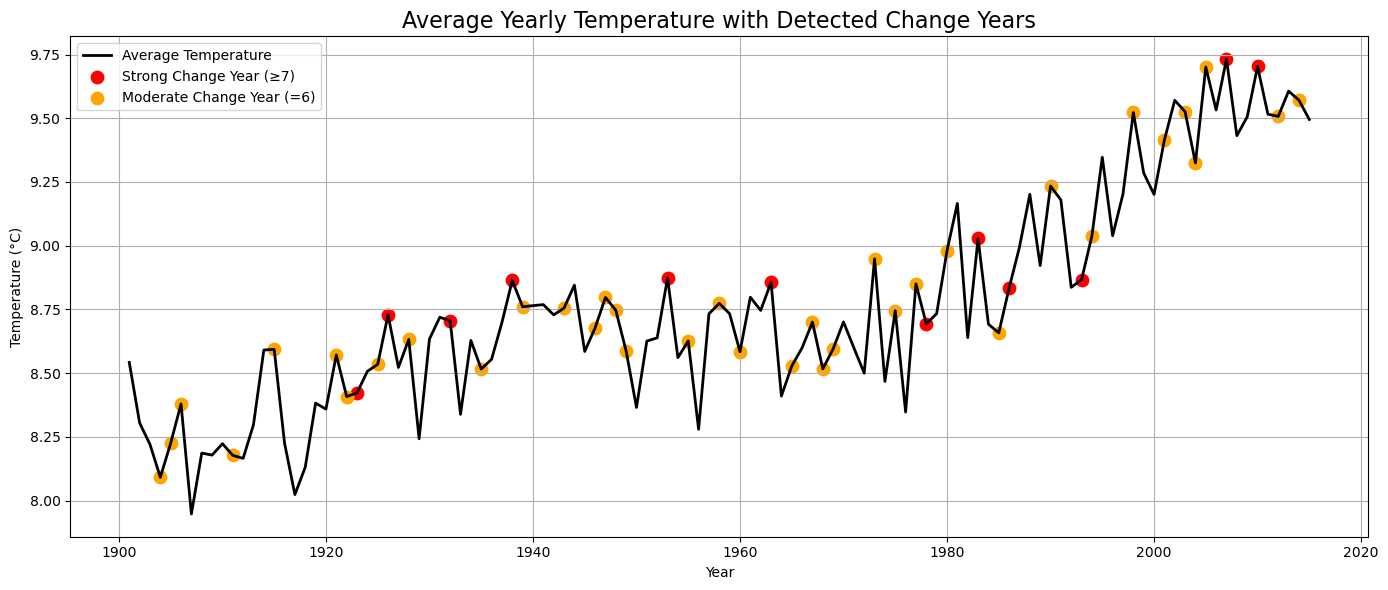

In [69]:
# Filter to keep data from year 1901 onwards
filtered_data = aligned_data[aligned_data.index.year >= 1901]

# Compute average temperature per year
yearly_avg_temp = filtered_data.groupby(filtered_data.index.year).mean()

#  Extract years with ≥ 7 and = 6 change-point months
strong_change_years = results_df[results_df['Change_Point_Months'] >= 7]['Year'].tolist()
moderate_change_years = results_df[results_df['Change_Point_Months'] == 6]['Year'].tolist()

#Plot the average temperature
plt.figure(figsize=(14, 6))
plt.plot(yearly_avg_temp.index, yearly_avg_temp.values, label='Average Temperature', color='black', linewidth=2)

#Strong change-point years (≥ 7)
for i, year in enumerate(strong_change_years):
    if year in yearly_avg_temp.index:
        plt.scatter(year, yearly_avg_temp.loc[year], color='red', s=80,
                    label='Strong Change Year (≥7)' if i == 0 else "")

#Moderate change-point years (= 6)
for i, year in enumerate(moderate_change_years):
    if year in yearly_avg_temp.index:
        plt.scatter(year, yearly_avg_temp.loc[year], color='orange', s=80,
                    label='Moderate Change Year (=6)' if i == 0 else "")

# Formatting
plt.title("Average Yearly Temperature with Detected Change Years", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()